# **Universidad Pontificia Bolivariana**
Facultad Ingeniería en Energía, Computación y TIC
Programas de Ingeniería en Sistemas e Informática – Ingeniería en Ciencia de Datos
**Curso de Tópicos Avanzados de Base de Datos**
NRC: 30286, 30578 – Periodo 202520





# 📊 Análisis Exploratorio de Datos - Calidad de Datos
## Sistema de Monitoreo de Temperatura - Antioquia

---

### 🎯 Objetivo
Identificar problemas de calidad de datos en las observaciones de temperatura registradas por estaciones en municipios de Antioquia, Colombia.

### 🔍 Aspectos Analizados
- **Completitud de datos**: Datos ausentes, gaps temporales
- **Consistencia temporal**: Frecuencia de medición, regularidad
- **Outliers**: Valores extremos y anómalos
- **Duplicados**: Registros repetidos
- **Calidad por dimensiones**: Estación, sensor, ubicación geográfica

### 🛠️ Tecnologías
- **Base de datos**: TimescaleDB + PostgreSQL 17.x
- **Análisis**: Python, Pandas, NumPy
- **Visualización**: Matplotlib, Seaborn, Plotly
---

In [1]:
# Configuración inicial del notebook
__version__ = "1.0.0"
__date__ = "2025-10-28"

print("="*80)
print("✓ Notebook inicializado correctamente")
print(f"  Versión: {__version__}")
print(f"  Fecha: {__date__}")
print("="*80)

✓ Notebook inicializado correctamente
  Versión: 1.0.0
  Fecha: 2025-10-28


---

## 1️⃣ Configuración y Conexión

### 📦 Instalación de Dependencias

Primero instalamos todas las librerías necesarias en el entorno virtual.

In [2]:
!pip install -v psycopg2-binary
!pip install -v sqlalchemy
!pip install -v pandas
!pip install -v numpy
!pip install -v matplotlib
!pip install -v seaborn
!pip install -v plotly
!pip install -v scipy
!pip install -v pytz
!pip install -v ipywidgets

print("\nLibrerias instaladas correctamente")


Using pip 25.3 from C:\z_academico\upb202520\202520_tadb\Proyectos de Clase\04 - Temperatura Antioquia\EDA_JupyterNotebook\.venv\Lib\site-packages\pip (python 3.13)
Using pip 25.3 from C:\z_academico\upb202520\202520_tadb\Proyectos de Clase\04 - Temperatura Antioquia\EDA_JupyterNotebook\.venv\Lib\site-packages\pip (python 3.13)
Using pip 25.3 from C:\z_academico\upb202520\202520_tadb\Proyectos de Clase\04 - Temperatura Antioquia\EDA_JupyterNotebook\.venv\Lib\site-packages\pip (python 3.13)
Using pip 25.3 from C:\z_academico\upb202520\202520_tadb\Proyectos de Clase\04 - Temperatura Antioquia\EDA_JupyterNotebook\.venv\Lib\site-packages\pip (python 3.13)
Using pip 25.3 from C:\z_academico\upb202520\202520_tadb\Proyectos de Clase\04 - Temperatura Antioquia\EDA_JupyterNotebook\.venv\Lib\site-packages\pip (python 3.13)
Using pip 25.3 from C:\z_academico\upb202520\202520_tadb\Proyectos de Clase\04 - Temperatura Antioquia\EDA_JupyterNotebook\.venv\Lib\site-packages\pip (python 3.13)
Using pip 

## 1️⃣ Configuración y Conexión

### 📚 Importación de Librerías

En esta sección importamos todas las librerías necesarias para:
- **Conexión a base de datos**: `psycopg2`, `sqlalchemy`
- **Manipulación de datos**: `pandas`, `numpy`
- **Visualización**: `matplotlib`, `seaborn`, `plotly`
- **Análisis estadístico**: `scipy`
- **Manejo de fechas**: `datetime`
- **Configuración**: `warnings`, `os`

In [3]:
# Librerías para conexión a base de datos
import psycopg2
from sqlalchemy import create_engine, text
import sqlalchemy as sa

# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import zscore

# Manejo de fechas y tiempo
from datetime import datetime, timedelta
import pytz

# Utilidades
import warnings
import os
from typing import Dict, List, Tuple, Optional

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("✓ Librerías importadas exitosamente")
print(f"  - pandas version: {pd.__version__}")
print(f"  - numpy version: {np.__version__}")
print(f"  - sqlalchemy version: {sa.__version__}")

✓ Librerías importadas exitosamente
  - pandas version: 2.3.3
  - numpy version: 2.3.4
  - sqlalchemy version: 2.0.44


### 🔌 Configuración de Conexión a TimescaleDB

Configuramos los parámetros de conexión a la base de datos PostgreSQL/TimescaleDB.

**Nota de seguridad**: En un entorno de producción, estas credenciales deberían estar en variables de entorno o en un archivo de configuración seguro (no versionado).

In [4]:
# Parámetros de conexión a la base de datos
# IMPORTANTE: Ajusta estos valores según tu configuración

DB_CONFIG = {
    'host': 'localhost',                    # Cambiar si la BD está en otro servidor
    'port': 5432,                           # Puerto por defecto de PostgreSQL
    'database': 'analisistemperatura_db',   # Nombre de tu base de datos
    'user': 'analisistemperatura_qry',      # Tu usuario de PostgreSQL
    'password': 'unaClav3'                  # Tu contraseña
}

# Crear string de conexión para SQLAlchemy
connection_string = (
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

# Crear engine de SQLAlchemy
try:
    engine = create_engine(connection_string)

    # Probar la conexión
    with engine.connect() as conn:
        result = conn.execute(text("SELECT version();"))
        version = result.fetchone()[0]

    print("✓ Conexión exitosa a la base de datos")
    print("="*80)
    print(f"  Base de datos: {DB_CONFIG['database']}")
    print(f"  Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    print(f"  Usuario: {DB_CONFIG['user']}")
    print("="*80)
    print(f"  PostgreSQL version: {version.split(',')[0]}")
    print("="*80)

except Exception as e:
    print("✗ Error al conectar con la base de datos")
    print(f"  Error: {str(e)}")
    print("\nVerifica:")
    print("  1. Que PostgreSQL esté ejecutándose")
    print("  2. Que los parámetros de conexión sean correctos")
    print("  3. Que el usuario tenga permisos suficientes")

✓ Conexión exitosa a la base de datos
  Base de datos: analisistemperatura_db
  Host: localhost:5432
  Usuario: analisistemperatura_qry
  PostgreSQL version: PostgreSQL 17.6 on x86_64-pc-linux-musl


### ⏱️ Verificación de TimescaleDB

Verificamos que la extensión TimescaleDB esté instalada y activa en la base de datos.

In [5]:
# Verificar que TimescaleDB está instalado y activo
try:
    with engine.connect() as conn:
        # Verificar extensión TimescaleDB
        result = conn.execute(text("""
            SELECT extname, extversion
            FROM pg_extension
            WHERE extname = 'timescaledb';
        """))
        timescale_info = result.fetchone()

        if timescale_info:
            print("✓ TimescaleDB está instalado y activo")
            print("="*80)
            print(f"  Extensión: {timescale_info[0]}")
            print(f"  Versión: {timescale_info[1]}")
            print("="*80)

            # Verificar hypertables existentes
            result = conn.execute(text("""
                SELECT hypertable_schema, hypertable_name, num_dimensions, num_chunks
                FROM timescaledb_information.hypertables;
            """))
            hypertables = result.fetchall()

            if hypertables:
                print(f"\n  Hypertables encontradas: {len(hypertables)}")
                for ht in hypertables:
                    print(f"    - {ht[0]}.{ht[1]} (Dimensiones: {ht[2]}, Chunks: {ht[3]})")
            else:
                print("\n  ⚠ No se encontraron hypertables configuradas")
        else:
            print("✗ TimescaleDB no está instalado en esta base de datos")
            print("  Por favor, instala la extensión con: CREATE EXTENSION IF NOT EXISTS timescaledb;")

except Exception as e:
    print("✗ Error al verificar TimescaleDB")
    print(f"  Error: {str(e)}")

✓ TimescaleDB está instalado y activo
  Extensión: timescaledb
  Versión: 2.22.1

  Hypertables encontradas: 1
    - public.observaciones (Dimensiones: 1, Chunks: 37)


### ⚙️ Parámetros Generales del Análisis

Definimos los parámetros y umbrales que utilizaremos para el análisis de calidad de datos.

In [6]:
# Parámetros temporales
PARAMS = {
    # Zona horaria
    'timezone': 'America/Bogota',

    # Rango de análisis (None = todos los datos disponibles)
    'fecha_inicio': '2025-01-01',  # Ejemplo: '2024-01-01'
    'fecha_fin': '2025-10-01',     # Ejemplo: '2024-12-31'

    # Umbrales de temperatura para Antioquia (°C)
    # Ajustar según altitud y características locales
    'temp_min_absoluta': 0,      # Temperatura mínima física esperada
    'temp_max_absoluta': 40,     # Temperatura máxima física esperada
    'temp_min_normal': 5,        # Temperatura mínima común
    'temp_max_normal': 35,       # Temperatura máxima común

    # Parámetros para detección de outliers
    'zscore_threshold': 3,       # Umbral para Z-score (desviaciones estándar)
    'iqr_multiplier': 1.5,       # Multiplicador para IQR

    # Parámetros de consistencia temporal
    'frecuencia_esperada_minutos': 60,  # Frecuencia esperada entre mediciones
    'gap_maximo_horas': 3,              # Gap máximo aceptable sin considerarlo problema

    # Parámetros de duplicados
    'tolerancia_tiempo_duplicados': 1,  # Minutos de tolerancia para cuasi-duplicados

    # Parámetros de visualización
    'figsize_default': (14, 6),
    'dpi': 100,
}

# Crear objeto timezone
tz = pytz.timezone(PARAMS['timezone'])

# Mostrar configuración
print("✓ Parámetros de análisis configurados")
print("="*80)
print("PARÁMETROS TEMPORALES:")
print(f"  Zona horaria: {PARAMS['timezone']}")
print(f"  Fecha inicio: {PARAMS['fecha_inicio'] or 'Todas las fechas'}")
print(f"  Fecha fin: {PARAMS['fecha_fin'] or 'Todas las fechas'}")
print("\nUMBRALES DE TEMPERATURA (°C):")
print(f"  Rango absoluto: [{PARAMS['temp_min_absoluta']}, {PARAMS['temp_max_absoluta']}]")
print(f"  Rango normal: [{PARAMS['temp_min_normal']}, {PARAMS['temp_max_normal']}]")
print("\nPARÁMETROS DE DETECCIÓN:")
print(f"  Z-score threshold: ±{PARAMS['zscore_threshold']} desviaciones estándar")
print(f"  IQR multiplier: {PARAMS['iqr_multiplier']}")
print(f"  Frecuencia esperada: {PARAMS['frecuencia_esperada_minutos']} minutos")
print(f"  Gap máximo aceptable: {PARAMS['gap_maximo_horas']} horas")
print("="*80)

✓ Parámetros de análisis configurados
PARÁMETROS TEMPORALES:
  Zona horaria: America/Bogota
  Fecha inicio: 2025-01-01
  Fecha fin: 2025-10-01

UMBRALES DE TEMPERATURA (°C):
  Rango absoluto: [0, 40]
  Rango normal: [5, 35]

PARÁMETROS DE DETECCIÓN:
  Z-score threshold: ±3 desviaciones estándar
  IQR multiplier: 1.5
  Frecuencia esperada: 60 minutos
  Gap máximo aceptable: 3 horas


---

## 2️⃣ Exploración Inicial del Modelo

### 📋 Inventario de Datos

Exploramos la estructura y volumen de datos en cada tabla del modelo para entender:
- Cantidad de registros por tabla
- Distribución geográfica (departamentos, zonas, municipios)
- Estaciones y sensores disponibles
- Período temporal cubierto por las observaciones
- Volumen total de observaciones

In [7]:
# Función auxiliar para ejecutar consultas
def ejecutar_query(query, descripcion=""):
    """Ejecuta una consulta y retorna un DataFrame"""
    try:
        with engine.connect() as conn:
            df = pd.read_sql(query, conn)
        return df
    except Exception as e:
        print(f"✗ Error en consulta {descripcion}: {str(e)}")
        return None

# Consultar conteo de registros en cada tabla
print("📊 INVENTARIO DE DATOS")
print("="*80)

tablas = ['departamentos', 'zonas', 'municipios', 'estaciones', 'sensores', 'observaciones']

for tabla in tablas:
    query = f"SELECT COUNT(*) as total FROM {tabla}"
    if tabla == 'observaciones' and (PARAMS['fecha_inicio'] or PARAMS['fecha_fin']):
        where_clauses = []
        if PARAMS['fecha_inicio']:
            where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
        if PARAMS['fecha_fin']:
            where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")
        query += " WHERE " + " AND ".join(where_clauses)

    result = ejecutar_query(query)
    if result is not None:
        total = result['total'].iloc[0]
        print(f"  {tabla.upper():20s}: {total:>15,} registros")

print("="*80)

📊 INVENTARIO DE DATOS
  DEPARTAMENTOS       :               1 registros
  ZONAS               :               5 registros
  MUNICIPIOS          :              36 registros
  ESTACIONES          :              43 registros
  SENSORES            :               2 registros
  OBSERVACIONES       :         486,307 registros


### 🗺️ Distribución Geográfica

Analizamos la distribución de estaciones por departamento, zona hidrográfica y municipio.

In [8]:
# Consultar distribución geográfica
query_geo = """
SELECT
    d.nombre as departamento,
    z.nombre as zona_hidrografica,
    COUNT(DISTINCT m.id) as num_municipios,
    COUNT(DISTINCT e.id) as num_estaciones
FROM departamentos d
LEFT JOIN municipios m ON d.id = m.departamento_id
LEFT JOIN zonas z ON m.zona_id = z.id
LEFT JOIN estaciones e ON m.id = e.municipio_id
GROUP BY d.nombre, z.nombre
ORDER BY d.nombre, z.nombre;
"""

df_geo = ejecutar_query(query_geo, "distribución geográfica")

if df_geo is not None:
    print("📍 DISTRIBUCIÓN GEOGRÁFICA")
    print("="*80)
    print(df_geo.to_string(index=False))
    print("="*80)
    print(f"\nRESUMEN:")
    print(f"  Total departamentos: {df_geo['departamento'].nunique()}")
    print(f"  Total zonas hidrográficas: {df_geo['zona_hidrografica'].nunique()}")
    print(f"  Total municipios: {df_geo['num_municipios'].sum()}")
    print(f"  Total estaciones: {df_geo['num_estaciones'].sum()}")
    print("="*80)

📍 DISTRIBUCIÓN GEOGRÁFICA
departamento zona_hidrografica  num_municipios  num_estaciones
   ANTIOQUIA   ATRATO - DARIÉN               5               6
   ANTIOQUIA  CARIBE - LITORAL               2               3
   ANTIOQUIA             CAUCA              10              11
   ANTIOQUIA   MEDIO MAGDALENA               8               9
   ANTIOQUIA             NECHÍ              11              14

RESUMEN:
  Total departamentos: 1
  Total zonas hidrográficas: 5
  Total municipios: 36
  Total estaciones: 43


### 🔧 Inventario de Estaciones y Sensores

Detallamos las estaciones de medición y los sensores utilizados en el sistema.

In [9]:
# Consultar información de estaciones
query_estaciones = """
SELECT
    e.id,
    e.nombre,
    m.nombre as municipio,
    d.nombre as departamento,
    e.latitud,
    e.longitud
FROM estaciones e
JOIN municipios m ON e.municipio_id = m.id
JOIN departamentos d ON m.departamento_id = d.id
ORDER BY d.nombre, m.nombre, e.nombre;
"""

df_estaciones = ejecutar_query(query_estaciones, "estaciones")

# Consultar información de sensores
query_sensores = """
SELECT
    id,
    nombre
FROM sensores
ORDER BY nombre;
"""

df_sensores = ejecutar_query(query_sensores, "sensores")

# Mostrar resultados
if df_estaciones is not None:
    print("🔬 ESTACIONES DE MEDICIÓN")
    print("="*100)
    # Crear copia para visualización con formato específico
    df_estaciones_display = df_estaciones.copy()
    df_estaciones_display['latitud'] = df_estaciones_display['latitud'].apply(lambda x: f'{x:.6f}')
    df_estaciones_display['longitud'] = df_estaciones_display['longitud'].apply(lambda x: f'{x:.6f}')
    print(df_estaciones_display.to_string(index=False))
    print("="*100)
    print(f"Total estaciones: {len(df_estaciones)}")
    print("="*100)

print("\n")

if df_sensores is not None:
    print("📡 SENSORES DISPONIBLES")
    print("="*100)
    print(df_sensores.to_string(index=False))
    print("="*100)
    print(f"Total sensores: {len(df_sensores)}")
    print("="*100)

🔬 ESTACIONES DE MEDICIÓN
        id                              nombre             municipio departamento  latitud   longitud
1111500036                            ABRIAQUI              ABRIAQUÍ    ANTIOQUIA 6.636300 -76.070733
2701500213                     ALTO DE LA CRUZ                AMALFI    ANTIOQUIA 6.910000 -75.078889
0027010850                              AMALFI                AMALFI    ANTIOQUIA 6.905556 -75.077222
2702500107                           ANGOSTURA             ANGOSTURA    ANTIOQUIA 6.900556 -75.326019
0027025030                               ANORI                 ANORÍ    ANTIOQUIA 7.071900 -75.150500
2620500209                   ACUEDUCTO ARMENIA               ARMENIA    ANTIOQUIA 6.161667 -75.775806
0027015310                       METROMEDELLIN                 BELLO    ANTIOQUIA 6.329750 -75.552111
0027015260                           LA SALADA                CALDAS    ANTIOQUIA 6.048361 -75.624667
0012015060                            TULENAPA           

### 📅 Período Temporal de los Datos

Analizamos el rango de fechas cubierto por las observaciones y el volumen de datos por período.

In [10]:
# Consultar período temporal de las observaciones
query_periodo = """
SELECT
    MIN(fecha) as primera_observacion,
    MAX(fecha) as ultima_observacion,
    MAX(fecha) - MIN(fecha) as duracion,
    COUNT(*) as total_observaciones,
    COUNT(DISTINCT estacion_id) as estaciones_con_datos,
    COUNT(DISTINCT sensor_id) as sensores_con_datos,
    COUNT(DISTINCT DATE(fecha)) as dias_con_datos
FROM observaciones
"""

# Agregar filtro de fechas si aplica
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")
if where_clauses:
    query_periodo += " WHERE " + " AND ".join(where_clauses)

df_periodo = ejecutar_query(query_periodo, "período temporal")

if df_periodo is not None:
    print("📅 PERÍODO TEMPORAL DE LOS DATOS")
    print("="*80)
    print(f"  Primera observación: {df_periodo['primera_observacion'].iloc[0]}")
    print(f"  Última observación:  {df_periodo['ultima_observacion'].iloc[0]}")
    print(f"  Duración total:      {df_periodo['duracion'].iloc[0]}")
    print(f"\n  Total observaciones:        {df_periodo['total_observaciones'].iloc[0]:>15,}")
    print(f"  Días con datos:             {df_periodo['dias_con_datos'].iloc[0]:>15,}")
    print(f"  Estaciones con datos:       {df_periodo['estaciones_con_datos'].iloc[0]:>15,}")
    print(f"  Sensores con datos:         {df_periodo['sensores_con_datos'].iloc[0]:>15,}")

    # Calcular estadísticas adicionales
    total_obs = df_periodo['total_observaciones'].iloc[0]
    dias = df_periodo['dias_con_datos'].iloc[0]
    if dias > 0:
        print(f"\n  Promedio observaciones/día: {total_obs/dias:>15,.1f}")
    print("="*80)

📅 PERÍODO TEMPORAL DE LOS DATOS
  Primera observación: 2025-01-01 00:00:00+00:00
  Última observación:  2025-09-30 23:58:00+00:00
  Duración total:      272 days 23:58:00

  Total observaciones:                486,307
  Días con datos:                         235
  Estaciones con datos:                    43
  Sensores con datos:                       2

  Promedio observaciones/día:         2,069.4


### 📊 Volumen de Observaciones por Período

Analizamos cómo se distribuyen las observaciones a lo largo del tiempo (por mes).

In [12]:
# Consultar volumen de observaciones por mes
query_volumen = """
SELECT
    DATE_TRUNC('month', fecha) as mes,
    COUNT(*) as num_observaciones,
    COUNT(DISTINCT estacion_id) as estaciones_activas,
    COUNT(DISTINCT sensor_id) as sensores_activos,
    COUNT(DISTINCT DATE(fecha)) as dias_con_datos,
    MIN(valor) as temp_minima,
    MAX(valor) as temp_maxima,
    AVG(valor) as temp_promedio
FROM observaciones
"""

# Agregar filtro de fechas si aplica
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")
if where_clauses:
    query_volumen += " WHERE " + " AND ".join(where_clauses)

query_volumen += """
GROUP BY DATE_TRUNC('month', fecha)
ORDER BY mes;
"""

df_volumen = ejecutar_query(query_volumen, "volumen por período")

if df_volumen is not None:
    print("📊 VOLUMEN DE OBSERVACIONES POR MES")
    print("="*120)

    # Formatear el DataFrame para visualización
    df_volumen_display = df_volumen.copy()
    df_volumen_display['mes'] = pd.to_datetime(df_volumen_display['mes']).dt.strftime('%Y-%m')
    df_volumen_display['num_observaciones'] = df_volumen_display['num_observaciones'].apply(lambda x: f'{x:,}')
    df_volumen_display['temp_minima'] = df_volumen_display['temp_minima'].apply(lambda x: f'{x:.2f}')
    df_volumen_display['temp_maxima'] = df_volumen_display['temp_maxima'].apply(lambda x: f'{x:.2f}')
    df_volumen_display['temp_promedio'] = df_volumen_display['temp_promedio'].apply(lambda x: f'{x:.2f}')

    print(df_volumen_display.to_string(index=False))
    print("="*120)

    # Estadísticas generales
    print(f"\nESTADÍSTICAS GENERALES:")
    print(f"  Total meses con datos: {len(df_volumen)}")
    print(f"  Promedio observaciones/mes: {df_volumen['num_observaciones'].mean():,.0f}")
    print(f"  Mes con más observaciones: {df_volumen.loc[df_volumen['num_observaciones'].idxmax(), 'mes'].strftime('%Y-%m')} ({df_volumen['num_observaciones'].max():,})")
    print(f"  Mes con menos observaciones: {df_volumen.loc[df_volumen['num_observaciones'].idxmin(), 'mes'].strftime('%Y-%m')} ({df_volumen['num_observaciones'].min():,})")
    print("="*120)

📊 VOLUMEN DE OBSERVACIONES POR MES
    mes num_observaciones  estaciones_activas  sensores_activos  dias_con_datos temp_minima temp_maxima temp_promedio
2025-01            62,425                  34                 2              31        0.00       47.90         19.69
2025-02            12,074                  34                 2               7        0.00       48.00         20.19
2025-03            57,962                  34                 2              30        0.00       50.00         19.73
2025-04            62,662                  32                 2              30        0.00       50.00         19.74
2025-05            41,389                  34                 2              20        0.00       50.00         19.47
2025-06            59,735                  35                 2              28        0.00       49.00         19.62
2025-07            65,224                  36                 2              31        0.00       50.00         20.42
2025-08            63

---

## 3️⃣ Análisis de Completitud de Datos

### 🔍 Datos Ausentes y Gaps Temporales

En esta sección analizamos:
- **Cobertura temporal**: Porcentaje de datos presentes vs esperados
- **Gaps temporales**: Períodos sin observaciones
- **Datos ausentes por estación**: Estaciones con problemas de completitud
- **Patrones de ausencia**: Identificación de patrones en los datos faltantes

In [13]:
# Consultar datos por estación
query_estaciones_datos = """
SELECT
    e.id as estacion_id,
    e.nombre as estacion,
    m.nombre as municipio,
    COUNT(DISTINCT o.sensor_id) as num_sensores,
    COUNT(*) as total_observaciones,
    MIN(o.fecha) as primera_obs,
    MAX(o.fecha) as ultima_obs,
    EXTRACT(EPOCH FROM (MAX(o.fecha) - MIN(o.fecha)))/3600 as horas_operacion,
    COUNT(DISTINCT DATE(o.fecha)) as dias_con_datos
FROM estaciones e
LEFT JOIN observaciones o ON e.id = o.estacion_id
JOIN municipios m ON e.municipio_id = m.id
{where_clause_o}
GROUP BY e.id, e.nombre, m.nombre
HAVING COUNT(*) > 0
ORDER BY total_observaciones DESC;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause_o = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""
where_clause_o = where_clause_o.replace("fecha", "o.fecha") if where_clause_o else ""

query_final = query_estaciones_datos.format(where_clause_o=where_clause_o)

df_estaciones_datos = ejecutar_query(query_final, "datos por estación")

if df_estaciones_datos is not None:
    print("📊 RESUMEN DE DATOS POR ESTACIÓN")
    print("="*80)

    # Formatear para visualización
    df_display = df_estaciones_datos.copy()
    df_display['total_observaciones'] = df_display['total_observaciones'].apply(lambda x: f'{x:,}')
    df_display['horas_operacion'] = df_display['horas_operacion'].apply(lambda x: f'{x:.1f}')

    print(df_display.to_string(index=False))
    print("="*80)

    # Estadísticas generales
    print(f"\nESTADÍSTICAS GENERALES:")
    print(f"  Total estaciones con datos: {len(df_estaciones_datos)}")
    print(f"  Promedio observaciones por estación: {df_estaciones_datos['total_observaciones'].mean():,.0f}")
    print(f"  Promedio días con datos: {df_estaciones_datos['dias_con_datos'].mean():.1f}")
    print(f"  Estación con más datos: {df_estaciones_datos.iloc[0]['estacion']} ({df_estaciones_datos.iloc[0]['total_observaciones']:,} obs)")
    print(f"  Estación con menos datos: {df_estaciones_datos.iloc[-1]['estacion']} ({df_estaciones_datos.iloc[-1]['total_observaciones']:,} obs)")
    print("="*80)

📊 RESUMEN DE DATOS POR ESTACIÓN
estacion_id                            estacion             municipio  num_sensores total_observaciones               primera_obs                ultima_obs horas_operacion  dias_con_datos
 0023085270             AEROPUERTO J.M. CORDOVA              RIONEGRO             2             165,404 2025-01-01 00:00:00+00:00 2025-09-30 23:58:00+00:00          6552.0             235
 0027015330            AEROPUERTO OLAYA HERRERA              MEDELLÍN             2             161,325 2025-01-01 00:00:00+00:00 2025-09-30 23:54:00+00:00          6551.9             235
 1111500036                            ABRIAQUI              ABRIAQUÍ             1               5,301 2025-01-01 00:00:00+00:00 2025-09-30 23:00:00+00:00          6551.0             223
 0027015310                       METROMEDELLIN                 BELLO             1               5,301 2025-01-01 00:00:00+00:00 2025-09-30 23:00:00+00:00          6551.0             223
 0023085260                 

### ⏳ Análisis de Gaps Temporales

Identificamos períodos sin observaciones (gaps) en cada estación para detectar interrupciones en la recolección de datos.

In [14]:
# Consultar gaps temporales por estación
query_gaps = """
WITH observaciones_ordenadas AS (
    SELECT
        estacion_id,
        fecha,
        LAG(fecha) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha) as fecha_anterior
    FROM observaciones
    {where_clause}
),
gaps_calculados AS (
    SELECT
        estacion_id,
        fecha_anterior as gap_inicio,
        fecha as gap_fin,
        EXTRACT(EPOCH FROM (fecha - fecha_anterior))/3600 as gap_horas
    FROM observaciones_ordenadas
    WHERE fecha_anterior IS NOT NULL
        AND EXTRACT(EPOCH FROM (fecha - fecha_anterior))/3600 > {gap_threshold}
)
SELECT
    e.nombre as estacion,
    m.nombre as municipio,
    COUNT(*) as num_gaps,
    MIN(g.gap_horas) as gap_minimo_horas,
    MAX(g.gap_horas) as gap_maximo_horas,
    AVG(g.gap_horas) as gap_promedio_horas,
    SUM(g.gap_horas) as total_horas_perdidas
FROM gaps_calculados g
JOIN estaciones e ON g.estacion_id = e.id
JOIN municipios m ON e.municipio_id = m.id
GROUP BY e.nombre, m.nombre
ORDER BY num_gaps DESC;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_gaps_final = query_gaps.format(
    where_clause=where_clause,
    gap_threshold=PARAMS['gap_maximo_horas']
)

df_gaps = ejecutar_query(query_gaps_final, "gaps temporales")

if df_gaps is not None and len(df_gaps) > 0:
    print("⏳ ANÁLISIS DE GAPS TEMPORALES")
    print("="*80)
    print(f"(Gaps > {PARAMS['gap_maximo_horas']} horas)")
    print("="*80)

    # Formatear para visualización
    df_gaps_display = df_gaps.copy()
    df_gaps_display['gap_minimo_horas'] = df_gaps_display['gap_minimo_horas'].apply(lambda x: f'{x:.1f}')
    df_gaps_display['gap_maximo_horas'] = df_gaps_display['gap_maximo_horas'].apply(lambda x: f'{x:.1f}')
    df_gaps_display['gap_promedio_horas'] = df_gaps_display['gap_promedio_horas'].apply(lambda x: f'{x:.1f}')
    df_gaps_display['total_horas_perdidas'] = df_gaps_display['total_horas_perdidas'].apply(lambda x: f'{x:.1f}')

    print(df_gaps_display.to_string(index=False))
    print("="*80)

    # Estadísticas de gaps
    print(f"\nESTADÍSTICAS DE GAPS:")
    print(f"  Total estaciones con gaps: {len(df_gaps)}")
    print(f"  Total gaps detectados: {df_gaps['num_gaps'].sum():,}")
    print(f"  Promedio gaps por estación: {df_gaps['num_gaps'].mean():.1f}")
    print(f"  Gap más largo: {df_gaps['gap_maximo_horas'].max():.1f} horas")
    print(f"  Total horas perdidas: {df_gaps['total_horas_perdidas'].sum():,.1f}")
    print("="*80)
else:
    print("⏳ ANÁLISIS DE GAPS TEMPORALES")
    print("="*80)
    print(f"✓ No se detectaron gaps mayores a {PARAMS['gap_maximo_horas']} horas")
    print("="*80)

⏳ ANÁLISIS DE GAPS TEMPORALES
(Gaps > 3 horas)
                           estacion             municipio  num_gaps gap_minimo_horas gap_maximo_horas gap_promedio_horas total_horas_perdidas
                      SANTA BARBARA         SANTA BÁRBARA       177              4.0            505.0               18.6               3293.0
                 LA ESPERANZA RADIO                 NECHÍ        60              4.0            522.0               52.1               3128.0
                   LA PALMA DE COCO               SEGOVIA        44              4.0            505.0               48.0               2111.0
                NORMAL SANTA TERESA              FRONTINO        40              4.0            621.0               58.6               2345.0
                   BOQUERON DE TOYO               GIRALDO        37              4.0            505.0               37.5               1388.0
                             SONSON                SONSÓN        31              4.0           1767.0

### 📈 Visualización de Gaps por Estación

Gráfico de barras mostrando las estaciones con más gaps temporales detectados.

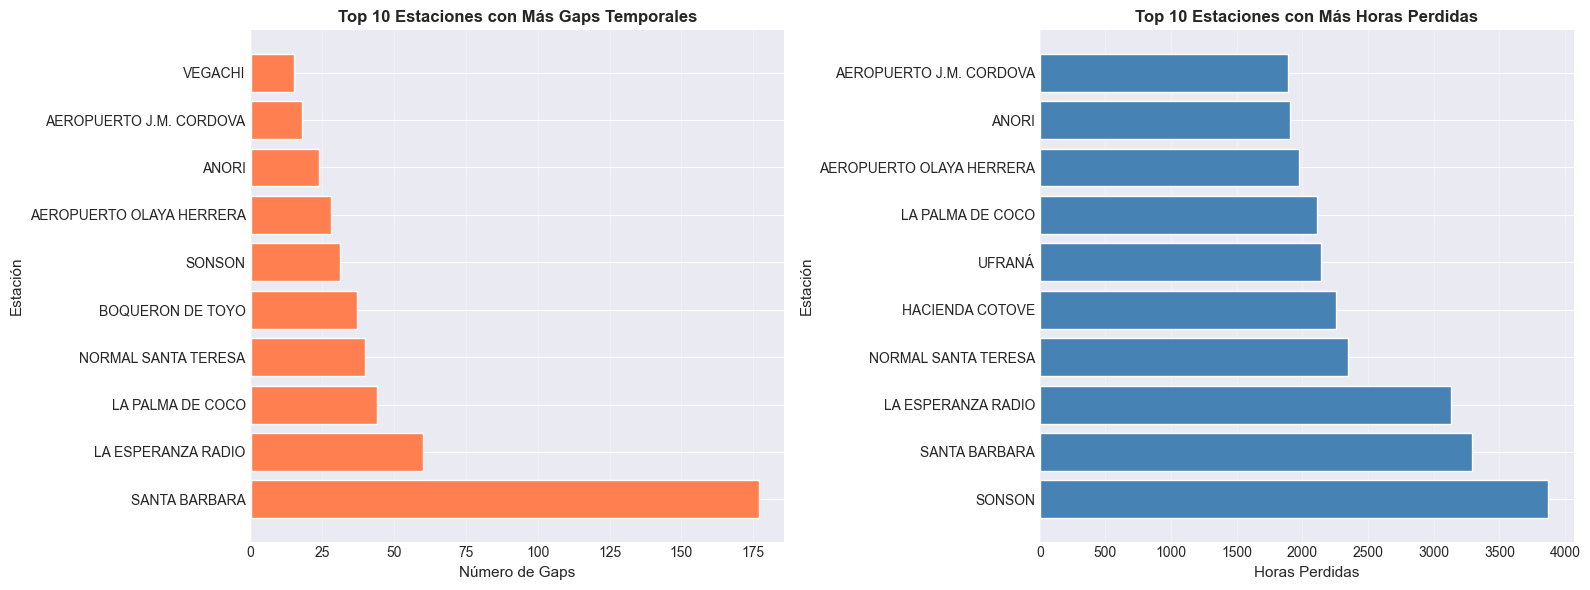

✓ Gráficos generados exitosamente


In [15]:
# Visualizar gaps por estación
if df_gaps is not None and len(df_gaps) > 0:
    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico 1: Número de gaps por estación (top 10)
    df_top_gaps = df_gaps.nlargest(10, 'num_gaps')
    ax1.barh(df_top_gaps['estacion'], df_top_gaps['num_gaps'], color='coral')
    ax1.set_xlabel('Número de Gaps', fontsize=11)
    ax1.set_ylabel('Estación', fontsize=11)
    ax1.set_title('Top 10 Estaciones con Más Gaps Temporales', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Gráfico 2: Total horas perdidas por estación (top 10)
    df_top_horas = df_gaps.nlargest(10, 'total_horas_perdidas')
    ax2.barh(df_top_horas['estacion'], df_top_horas['total_horas_perdidas'], color='steelblue')
    ax2.set_xlabel('Horas Perdidas', fontsize=11)
    ax2.set_ylabel('Estación', fontsize=11)
    ax2.set_title('Top 10 Estaciones con Más Horas Perdidas', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Gráficos generados exitosamente")
else:
    print("ℹ️  No hay gaps que visualizar")

---

## 4️⃣ Análisis de Consistencia Temporal

### ⏱️ Frecuencia de Medición

Analizamos la regularidad en los intervalos entre observaciones consecutivas para identificar:
- Frecuencia de muestreo predominante
- Variabilidad en los intervalos
- Cambios en patrones de medición

In [34]:
# Analizar intervalos entre observaciones
query_intervalos = """
WITH intervalos AS (
    SELECT
        estacion_id,
        sensor_id,
        fecha,
        LAG(fecha) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha) as fecha_anterior,
        EXTRACT(EPOCH FROM (fecha - LAG(fecha) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha)))/60 as intervalo_minutos
    FROM observaciones
    {where_clause}
)
SELECT
    e.nombre as estacion,
    s.nombre as sensor,
    COUNT(*) as num_intervalos,
    MIN(i.intervalo_minutos) as intervalo_min,
    MAX(i.intervalo_minutos) as intervalo_max,
    AVG(i.intervalo_minutos) as intervalo_promedio,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY i.intervalo_minutos) as intervalo_mediana,
    STDDEV(i.intervalo_minutos) as intervalo_stddev
FROM intervalos i
JOIN estaciones e ON i.estacion_id = e.id
JOIN sensores s ON i.sensor_id = s.id
WHERE i.intervalo_minutos IS NOT NULL
    AND i.intervalo_minutos > 0
    AND i.intervalo_minutos <= {max_intervalo}
GROUP BY e.nombre, s.nombre
ORDER BY e.nombre, s.nombre;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_intervalos_final = query_intervalos.format(
    where_clause=where_clause,
    max_intervalo=PARAMS['gap_maximo_horas'] * 60  # Convertir a minutos
)

df_intervalos = ejecutar_query(query_intervalos_final, "frecuencia de medición")

if df_intervalos is not None and len(df_intervalos) > 0:
    print("⏱️  ANÁLISIS DE FRECUENCIA DE MEDICIÓN")
    print("="*80)
    print(f"(Intervalos ≤ {PARAMS['gap_maximo_horas']} horas)")
    print("="*80)

    # Formatear para visualización
    df_intervalos_display = df_intervalos.copy()
    df_intervalos_display['intervalo_min'] = df_intervalos_display['intervalo_min'].apply(lambda x: f'{x:.1f}')
    df_intervalos_display['intervalo_max'] = df_intervalos_display['intervalo_max'].apply(lambda x: f'{x:.1f}')
    df_intervalos_display['intervalo_promedio'] = df_intervalos_display['intervalo_promedio'].apply(lambda x: f'{x:.1f}')
    df_intervalos_display['intervalo_mediana'] = df_intervalos_display['intervalo_mediana'].apply(lambda x: f'{x:.1f}')
    df_intervalos_display['intervalo_stddev'] = df_intervalos_display['intervalo_stddev'].apply(lambda x: f'{x:.1f}')

    print(df_intervalos_display.to_string(index=False))
    print("="*80)

    # Estadísticas generales
    print(f"\nESTADÍSTICAS GENERALES:")
    print(f"  Intervalo promedio global: {df_intervalos['intervalo_promedio'].mean():.1f} minutos")
    print(f"  Intervalo mediano global: {df_intervalos['intervalo_mediana'].median():.1f} minutos")
    print(f"  Frecuencia esperada: {PARAMS['frecuencia_esperada_minutos']} minutos")
    print(f"  Desviación estándar promedio: {df_intervalos['intervalo_stddev'].mean():.1f} minutos")
    print("="*80)
else:
    print("⏱️  No se encontraron datos de intervalos para analizar")

⏱️  ANÁLISIS DE FRECUENCIA DE MEDICIÓN
(Intervalos ≤ 3 horas)
                           estacion                            sensor  num_intervalos intervalo_min intervalo_max intervalo_promedio intervalo_mediana intervalo_stddev
                           ABRIAQUI        TEMPERATURA DEL AIRE A 2 m            5291          60.0          60.0               60.0              60.0              0.0
                  ACUEDUCTO ARMENIA        TEMPERATURA DEL AIRE A 2 m            5259          60.0         180.0               60.5              60.0              6.4
            AEROPUERTO J.M. CORDOVA GPRS - TEMPERATURA DEL AIRE A 2 m          160047           1.0         146.0                2.1               2.0              0.8
            AEROPUERTO J.M. CORDOVA        TEMPERATURA DEL AIRE A 2 m            5337          60.0         180.0               63.0              60.0             13.4
           AEROPUERTO OLAYA HERRERA GPRS - TEMPERATURA DEL AIRE A 2 m          156067           1.

### 📊 Distribución de Intervalos de Medición

Histograma mostrando la distribución de los intervalos entre observaciones para identificar la frecuencia predominante.

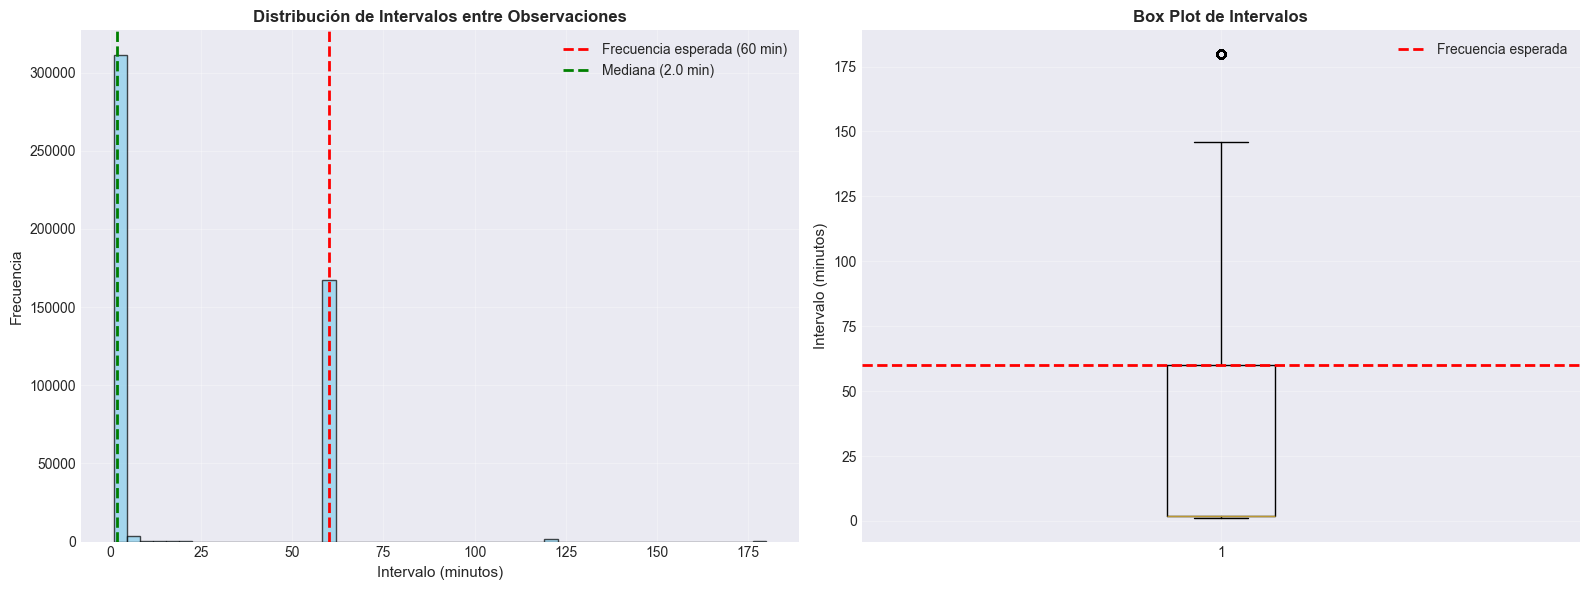

📊 ESTADÍSTICAS DE DISTRIBUCIÓN DE INTERVALOS
  Total intervalos analizados: 485,511
  Media: 22.55 minutos
  Mediana: 2.00 minutos
  Moda: 2.00 minutos
  Desviación estándar: 28.22 minutos
  Percentil 25: 2.00 minutos
  Percentil 75: 60.00 minutos


In [35]:
# Consultar todos los intervalos para histograma
query_intervalos_dist = """
WITH intervalos AS (
    SELECT
        estacion_id,
        sensor_id,
        EXTRACT(EPOCH FROM (fecha - LAG(fecha) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha)))/60 as intervalo_minutos
    FROM observaciones
    {where_clause}
)
SELECT intervalo_minutos
FROM intervalos
WHERE intervalo_minutos IS NOT NULL
    AND intervalo_minutos > 0
    AND intervalo_minutos <= {max_intervalo};
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_intervalos_dist_final = query_intervalos_dist.format(
    where_clause=where_clause,
    max_intervalo=PARAMS['gap_maximo_horas'] * 60
)

df_intervalos_dist = ejecutar_query(query_intervalos_dist_final, "distribución de intervalos")

if df_intervalos_dist is not None and len(df_intervalos_dist) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Histograma completo
    ax1.hist(df_intervalos_dist['intervalo_minutos'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(PARAMS['frecuencia_esperada_minutos'], color='red', linestyle='--', linewidth=2, label=f'Frecuencia esperada ({PARAMS["frecuencia_esperada_minutos"]} min)')
    ax1.axvline(df_intervalos_dist['intervalo_minutos'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana ({df_intervalos_dist["intervalo_minutos"].median():.1f} min)')
    ax1.set_xlabel('Intervalo (minutos)', fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.set_title('Distribución de Intervalos entre Observaciones', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Box plot
    ax2.boxplot(df_intervalos_dist['intervalo_minutos'], vert=True)
    ax2.axhline(PARAMS['frecuencia_esperada_minutos'], color='red', linestyle='--', linewidth=2, label=f'Frecuencia esperada')
    ax2.set_ylabel('Intervalo (minutos)', fontsize=11)
    ax2.set_title('Box Plot de Intervalos', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Estadísticas adicionales
    print("📊 ESTADÍSTICAS DE DISTRIBUCIÓN DE INTERVALOS")
    print("="*80)
    print(f"  Total intervalos analizados: {len(df_intervalos_dist):,}")
    print(f"  Media: {df_intervalos_dist['intervalo_minutos'].mean():.2f} minutos")
    print(f"  Mediana: {df_intervalos_dist['intervalo_minutos'].median():.2f} minutos")
    print(f"  Moda: {df_intervalos_dist['intervalo_minutos'].mode()[0]:.2f} minutos")
    print(f"  Desviación estándar: {df_intervalos_dist['intervalo_minutos'].std():.2f} minutos")
    print(f"  Percentil 25: {df_intervalos_dist['intervalo_minutos'].quantile(0.25):.2f} minutos")
    print(f"  Percentil 75: {df_intervalos_dist['intervalo_minutos'].quantile(0.75):.2f} minutos")
    print("="*80)
else:
    print("ℹ️  No hay datos de intervalos para visualizar")

---

## 5️⃣ Detección de Outliers

### 🔍 Valores Extremos y Anómalos

Identificamos valores de temperatura que se consideran outliers utilizando diferentes métodos:
- **Límites físicos**: Valores fuera del rango esperado para Antioquia
- **Método IQR**: Valores fuera del rango intercuartílico
- **Método Z-score**: Valores con desviaciones estándar extremas
- **Outliers contextuales**: Valores anómalos según ubicación/estación

In [18]:
# Consultar estadísticas básicas de temperatura
query_temp_stats = """
SELECT
    e.nombre as estacion,
    m.nombre as municipio,
    s.nombre as sensor,
    COUNT(*) as num_observaciones,
    MIN(o.valor) as temp_minima,
    MAX(o.valor) as temp_maxima,
    AVG(o.valor) as temp_promedio,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY o.valor) as percentil_25,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY o.valor) as mediana,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY o.valor) as percentil_75,
    STDDEV(o.valor) as desviacion_std
FROM observaciones o
JOIN estaciones e ON o.estacion_id = e.id
JOIN municipios m ON e.municipio_id = m.id
JOIN sensores s ON o.sensor_id = s.id
{where_clause}
GROUP BY e.nombre, m.nombre, s.nombre
ORDER BY e.nombre, s.nombre;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"o.fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"o.fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_temp_stats_final = query_temp_stats.format(where_clause=where_clause)

df_temp_stats = ejecutar_query(query_temp_stats_final, "estadísticas de temperatura")

if df_temp_stats is not None and len(df_temp_stats) > 0:
    print("🌡️  ESTADÍSTICAS DE TEMPERATURA POR ESTACIÓN Y SENSOR")
    print("="*80)

    # Formatear para visualización
    df_temp_display = df_temp_stats.copy()
    for col in ['temp_minima', 'temp_maxima', 'temp_promedio', 'percentil_25', 'mediana', 'percentil_75', 'desviacion_std']:
        df_temp_display[col] = df_temp_display[col].apply(lambda x: f'{x:.2f}')

    print(df_temp_display.to_string(index=False))
    print("="*80)

    # Estadísticas globales
    print(f"\nESTADÍSTICAS GLOBALES:")
    print(f"  Temperatura mínima registrada: {df_temp_stats['temp_minima'].min():.2f}°C")
    print(f"  Temperatura máxima registrada: {df_temp_stats['temp_maxima'].max():.2f}°C")
    print(f"  Temperatura promedio global: {df_temp_stats['temp_promedio'].mean():.2f}°C")
    print(f"  Desviación estándar promedio: {df_temp_stats['desviacion_std'].mean():.2f}°C")
    print("="*80)

    # Guardar para uso posterior
    df_temp_stats_global = df_temp_stats.copy()
else:
    print("⚠️  No se encontraron datos de temperatura para analizar")

🌡️  ESTADÍSTICAS DE TEMPERATURA POR ESTACIÓN Y SENSOR
                           estacion             municipio                            sensor  num_observaciones temp_minima temp_maxima temp_promedio percentil_25 mediana percentil_75 desviacion_std
                           ABRIAQUI              ABRIAQUÍ        TEMPERATURA DEL AIRE A 2 m               5301        7.00       30.40         17.42        14.40   16.20        20.40           4.13
                  ACUEDUCTO ARMENIA               ARMENIA        TEMPERATURA DEL AIRE A 2 m               5274       13.50       44.30         18.92        16.60   18.20        20.70           3.03
            AEROPUERTO J.M. CORDOVA              RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m             160057        0.00       50.00         17.03        14.70   15.90        19.80           3.39
            AEROPUERTO J.M. CORDOVA              RIONEGRO        TEMPERATURA DEL AIRE A 2 m               5347        0.00       25.00         17.04      

### 🚨 Outliers por Límites Físicos

Identificamos valores que están fuera de los rangos físicos esperados para temperaturas en Antioquia.

In [36]:
# Detectar outliers por límites físicos
query_outliers_fisicos = """
SELECT
    e.nombre as estacion,
    m.nombre as municipio,
    s.nombre as sensor,
    o.fecha,
    o.valor as temperatura,
    CASE
        WHEN o.valor < {temp_min_abs} THEN 'Debajo del mínimo absoluto'
        WHEN o.valor > {temp_max_abs} THEN 'Encima del máximo absoluto'
        WHEN o.valor < {temp_min_normal} THEN 'Debajo del mínimo normal'
        WHEN o.valor > {temp_max_normal} THEN 'Encima del máximo normal'
    END as tipo_outlier
FROM observaciones o
JOIN estaciones e ON o.estacion_id = e.id
JOIN municipios m ON e.municipio_id = m.id
JOIN sensores s ON o.sensor_id = s.id
WHERE (o.valor < {temp_min_abs} OR o.valor > {temp_max_abs}
       OR o.valor < {temp_min_normal} OR o.valor > {temp_max_normal})
{and_where_clause}
ORDER BY o.valor DESC;
"""

# Construir cláusulas WHERE adicionales
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"o.fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"o.fecha <= '{PARAMS['fecha_fin']}'")

and_where_clause = ("AND " + " AND ".join(where_clauses)) if where_clauses else ""

query_outliers_fisicos_final = query_outliers_fisicos.format(
    temp_min_abs=PARAMS['temp_min_absoluta'],
    temp_max_abs=PARAMS['temp_max_absoluta'],
    temp_min_normal=PARAMS['temp_min_normal'],
    temp_max_normal=PARAMS['temp_max_normal'],
    and_where_clause=and_where_clause
)

df_outliers_fisicos = ejecutar_query(query_outliers_fisicos_final, "outliers por límites físicos")

if df_outliers_fisicos is not None and len(df_outliers_fisicos) > 0:
    print("🚨 OUTLIERS POR LÍMITES FÍSICOS")
    print("="*80)
    print(f"Rangos configurados:")
    print(f"  - Rango absoluto: [{PARAMS['temp_min_absoluta']}°C, {PARAMS['temp_max_absoluta']}°C]")
    print(f"  - Rango normal: [{PARAMS['temp_min_normal']}°C, {PARAMS['temp_max_normal']}°C]")
    print("="*80)

    # Mostrar los primeros 20 outliers
    print(f"\nPrimeros 20 outliers detectados (de {len(df_outliers_fisicos)} totales):")
    print(df_outliers_fisicos.head(20).to_string(index=False))
    print("="*80)

    # Resumen por tipo
    print(f"\nRESUMEN POR TIPO DE OUTLIER:")
    resumen_tipo = df_outliers_fisicos.groupby('tipo_outlier').size().reset_index(name='cantidad')
    print(resumen_tipo.to_string(index=False))
    print("="*80)

    # Resumen por estación
    print(f"\nESTACIONES CON MÁS OUTLIERS FÍSICOS:")
    resumen_estacion = df_outliers_fisicos.groupby(['estacion', 'municipio']).size().reset_index(name='cantidad')
    resumen_estacion = resumen_estacion.sort_values('cantidad', ascending=False).head(10)
    print(resumen_estacion.to_string(index=False))
    print("="*80)

    # Guardar para análisis posterior
    df_outliers_fisicos_global = df_outliers_fisicos.copy()
else:
    print("🚨 OUTLIERS POR LÍMITES FÍSICOS")
    print("="*80)
    print("✓ No se detectaron outliers por límites físicos")
    print("="*80)

🚨 OUTLIERS POR LÍMITES FÍSICOS
Rangos configurados:
  - Rango absoluto: [0°C, 40°C]
  - Rango normal: [5°C, 35°C]

Primeros 20 outliers detectados (de 1953 totales):
                estacion municipio                            sensor                     fecha  temperatura               tipo_outlier
AEROPUERTO OLAYA HERRERA  MEDELLÍN GPRS - TEMPERATURA DEL AIRE A 2 m 2025-05-02 14:26:00+00:00        50.00 Encima del máximo absoluto
AEROPUERTO OLAYA HERRERA  MEDELLÍN GPRS - TEMPERATURA DEL AIRE A 2 m 2025-07-02 00:06:00+00:00        50.00 Encima del máximo absoluto
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-03-16 10:38:00+00:00        50.00 Encima del máximo absoluto
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-04-05 06:16:00+00:00        50.00 Encima del máximo absoluto
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-04-05 01:16:00+00:00        50.00 Encima del máximo absoluto
AEROPUERTO OLAYA HERRERA

### 📊 Outliers por Método IQR (Rango Intercuartílico)

Identificamos outliers usando el método IQR: valores que están fuera del rango [Q1 - 1.5×IQR, Q3 + 1.5×IQR] para cada estación y sensor.

In [37]:
# Detectar outliers por método IQR
query_outliers_iqr = """
WITH stats_por_estacion_sensor AS (
    SELECT
        estacion_id,
        sensor_id,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY valor) as q1,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY valor) as q3,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY valor) -
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY valor) as iqr
    FROM observaciones
    {where_clause}
    GROUP BY estacion_id, sensor_id
),
outliers AS (
    SELECT
        o.estacion_id,
        o.sensor_id,
        o.fecha,
        o.valor,
        s.q1,
        s.q3,
        s.iqr,
        s.q1 - ({iqr_mult} * s.iqr) as limite_inferior,
        s.q3 + ({iqr_mult} * s.iqr) as limite_superior,
        CASE
            WHEN o.valor < (s.q1 - ({iqr_mult} * s.iqr)) THEN 'Inferior'
            WHEN o.valor > (s.q3 + ({iqr_mult} * s.iqr)) THEN 'Superior'
        END as tipo_outlier
    FROM observaciones o
    JOIN stats_por_estacion_sensor s ON o.estacion_id = s.estacion_id AND o.sensor_id = s.sensor_id
    WHERE o.valor < (s.q1 - ({iqr_mult} * s.iqr))
       OR o.valor > (s.q3 + ({iqr_mult} * s.iqr))
    {and_where_clause}
)
SELECT
    e.nombre as estacion,
    m.nombre as municipio,
    sen.nombre as sensor,
    out.fecha,
    out.valor as temperatura,
    ROUND(out.q1::numeric, 2) as q1,
    ROUND(out.q3::numeric, 2) as q3,
    ROUND(out.iqr::numeric, 2) as iqr,
    ROUND(out.limite_inferior::numeric, 2) as limite_inf,
    ROUND(out.limite_superior::numeric, 2) as limite_sup,
    out.tipo_outlier
FROM outliers out
JOIN estaciones e ON out.estacion_id = e.id
JOIN municipios m ON e.municipio_id = m.id
JOIN sensores sen ON out.sensor_id = sen.id
ORDER BY out.valor DESC;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""
and_where_clause = ("AND " + " AND ".join(where_clauses)) if where_clauses else ""

query_outliers_iqr_final = query_outliers_iqr.format(
    where_clause=where_clause,
    and_where_clause=and_where_clause,
    iqr_mult=PARAMS['iqr_multiplier']
)

df_outliers_iqr = ejecutar_query(query_outliers_iqr_final, "outliers por IQR")

if df_outliers_iqr is not None and len(df_outliers_iqr) > 0:
    print("📊 OUTLIERS POR MÉTODO IQR")
    print("="*80)
    print(f"Multiplicador IQR: {PARAMS['iqr_multiplier']}")
    print(f"Fórmula: [Q1 - {PARAMS['iqr_multiplier']}×IQR, Q3 + {PARAMS['iqr_multiplier']}×IQR]")
    print("="*80)

    # Mostrar los primeros 20 outliers
    print(f"\nPrimeros 20 outliers detectados (de {len(df_outliers_iqr)} totales):")
    print(df_outliers_iqr.head(20).to_string(index=False))
    print("="*80)

    # Resumen por tipo
    print(f"\nRESUMEN POR TIPO DE OUTLIER:")
    resumen_tipo = df_outliers_iqr.groupby('tipo_outlier').size().reset_index(name='cantidad')
    print(resumen_tipo.to_string(index=False))
    print("="*80)

    # Resumen por estación
    print(f"\nESTACIONES CON MÁS OUTLIERS IQR:")
    resumen_estacion = df_outliers_iqr.groupby(['estacion', 'municipio']).size().reset_index(name='cantidad')
    resumen_estacion = resumen_estacion.sort_values('cantidad', ascending=False).head(10)
    print(resumen_estacion.to_string(index=False))
    print("="*80)

    # Guardar para análisis posterior
    df_outliers_iqr_global = df_outliers_iqr.copy()
else:
    print("📊 OUTLIERS POR MÉTODO IQR")
    print("="*80)
    print("✓ No se detectaron outliers usando método IQR")
    print("="*80)

📊 OUTLIERS POR MÉTODO IQR
Multiplicador IQR: 1.5
Fórmula: [Q1 - 1.5×IQR, Q3 + 1.5×IQR]

Primeros 20 outliers detectados (de 3018 totales):
                estacion municipio                            sensor                     fecha  temperatura    q1    q3  iqr  limite_inf  limite_sup tipo_outlier
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-03-16 10:38:00+00:00        50.00 14.70 19.80 5.10        7.05       27.45     Superior
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-04-05 01:16:00+00:00        50.00 14.70 19.80 5.10        7.05       27.45     Superior
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-04-05 06:16:00+00:00        50.00 14.70 19.80 5.10        7.05       27.45     Superior
AEROPUERTO OLAYA HERRERA  MEDELLÍN GPRS - TEMPERATURA DEL AIRE A 2 m 2025-05-02 14:26:00+00:00        50.00 19.30 24.60 5.30       11.35       32.55     Superior
AEROPUERTO OLAYA HERRERA  MEDELLÍN GPRS - TEMPERATU

### 📊 Visualización de Outliers Detectados

Gráficos comparativos de los outliers detectados por cada método.

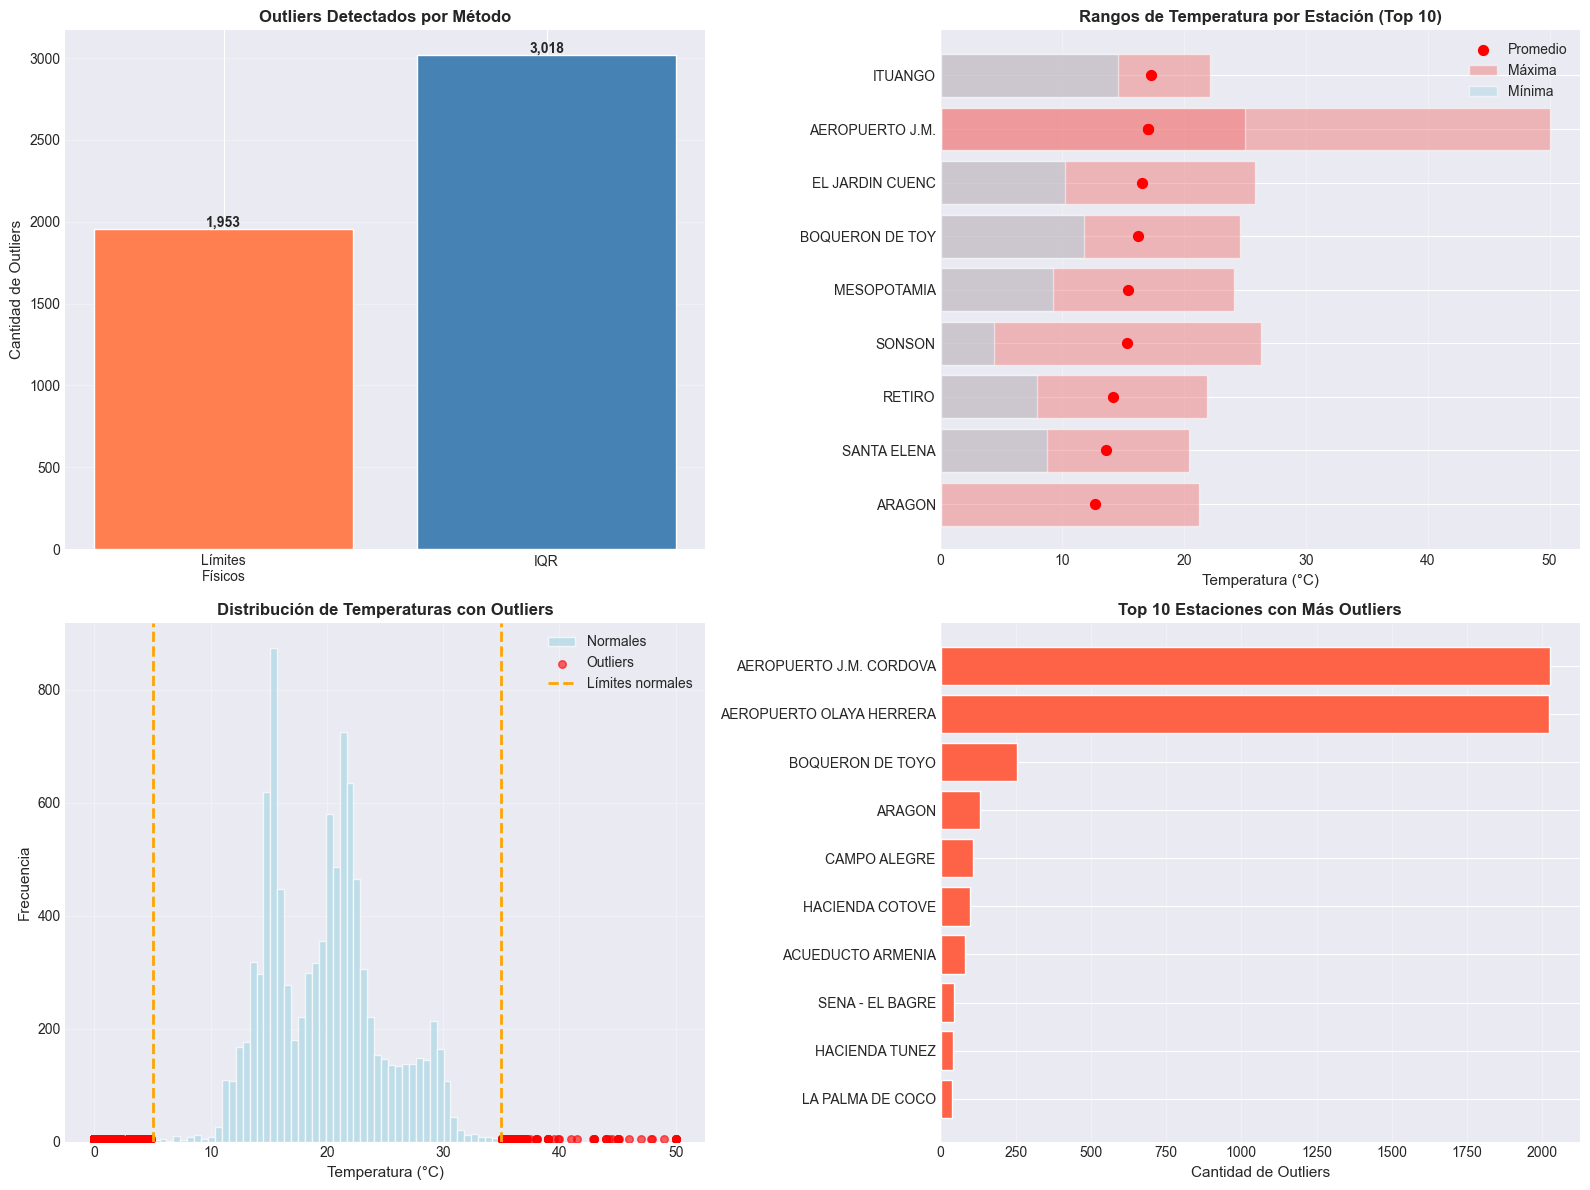

✓ Visualizaciones de outliers generadas exitosamente


In [38]:
# Visualizar outliers detectados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Resumen de outliers por método
metodos = []
cantidades = []

if 'df_outliers_fisicos_global' in globals() and len(df_outliers_fisicos_global) > 0:
    metodos.append('Límites\nFísicos')
    cantidades.append(len(df_outliers_fisicos_global))

if 'df_outliers_iqr_global' in globals() and len(df_outliers_iqr_global) > 0:
    metodos.append('IQR')
    cantidades.append(len(df_outliers_iqr_global))

if 'df_outliers_zscore_global' in globals() and len(df_outliers_zscore_global) > 0:
    metodos.append('Z-score')
    cantidades.append(len(df_outliers_zscore_global))

if metodos:
    axes[0, 0].bar(metodos, cantidades, color=['coral', 'steelblue', 'seagreen'])
    axes[0, 0].set_ylabel('Cantidad de Outliers', fontsize=11)
    axes[0, 0].set_title('Outliers Detectados por Método', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Añadir valores en las barras
    for i, v in enumerate(cantidades):
        axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'No se detectaron outliers', ha='center', va='center', fontsize=12)
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)

# Gráfico 2: Box plot de temperaturas por estación (si hay datos)
if 'df_temp_stats_global' in globals() and len(df_temp_stats_global) > 0:
    # Tomar solo las primeras 10 estaciones para legibilidad
    estaciones_top = df_temp_stats_global.nsmallest(10, 'temp_promedio')

    positions = range(len(estaciones_top))
    bp_data = []
    labels = []

    for _, row in estaciones_top.iterrows():
        # Simular box plot con los percentiles disponibles
        labels.append(row['estacion'][:15])  # Truncar nombre

    axes[0, 1].barh(labels, estaciones_top['temp_maxima'], color='lightcoral', alpha=0.5, label='Máxima')
    axes[0, 1].barh(labels, estaciones_top['temp_minima'], color='lightblue', alpha=0.5, label='Mínima')
    axes[0, 1].scatter(estaciones_top['temp_promedio'], labels, color='red', s=50, zorder=3, label='Promedio')
    axes[0, 1].set_xlabel('Temperatura (°C)', fontsize=11)
    axes[0, 1].set_title('Rangos de Temperatura por Estación (Top 10)', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No hay datos disponibles', ha='center', va='center', fontsize=12)

# Gráfico 3: Distribución de temperaturas con outliers marcados
if 'df_outliers_fisicos_global' in globals() and len(df_outliers_fisicos_global) > 0:
    # Obtener muestra de temperaturas normales
    query_sample = """
    SELECT valor FROM observaciones
    WHERE valor >= {temp_min} AND valor <= {temp_max}
    {where_clause}
    LIMIT 10000;
    """.format(
        temp_min=PARAMS['temp_min_normal'],
        temp_max=PARAMS['temp_max_normal'],
        where_clause=("AND " + " AND ".join([f"fecha >= '{PARAMS['fecha_inicio']}'" if PARAMS['fecha_inicio'] else "",
                                              f"fecha <= '{PARAMS['fecha_fin']}'" if PARAMS['fecha_fin'] else ""])).rstrip('AND ')
    )

    df_sample = ejecutar_query(query_sample, "muestra temperaturas")

    if df_sample is not None and len(df_sample) > 0:
        axes[1, 0].hist(df_sample['valor'], bins=50, color='lightblue', alpha=0.7, label='Normales')
        axes[1, 0].scatter(df_outliers_fisicos_global['temperatura'],
                          [5] * len(df_outliers_fisicos_global),
                          color='red', s=30, alpha=0.6, label='Outliers')
        axes[1, 0].axvline(PARAMS['temp_min_normal'], color='orange', linestyle='--', linewidth=2, label='Límites normales')
        axes[1, 0].axvline(PARAMS['temp_max_normal'], color='orange', linestyle='--', linewidth=2)
        axes[1, 0].set_xlabel('Temperatura (°C)', fontsize=11)
        axes[1, 0].set_ylabel('Frecuencia', fontsize=11)
        axes[1, 0].set_title('Distribución de Temperaturas con Outliers', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No hay outliers para visualizar', ha='center', va='center', fontsize=12)

# Gráfico 4: Top estaciones con outliers
if metodos and cantidades:
    all_outliers = []

    if 'df_outliers_fisicos_global' in globals() and len(df_outliers_fisicos_global) > 0:
        all_outliers.append(df_outliers_fisicos_global[['estacion', 'municipio']])
    if 'df_outliers_iqr_global' in globals() and len(df_outliers_iqr_global) > 0:
        all_outliers.append(df_outliers_iqr_global[['estacion', 'municipio']])
    if 'df_outliers_zscore_global' in globals() and len(df_outliers_zscore_global) > 0:
        all_outliers.append(df_outliers_zscore_global[['estacion', 'municipio']])

    if all_outliers:
        df_all_outliers = pd.concat(all_outliers, ignore_index=True)
        top_estaciones = df_all_outliers.groupby('estacion').size().reset_index(name='cantidad')
        top_estaciones = top_estaciones.sort_values('cantidad', ascending=True).tail(10)

        axes[1, 1].barh(top_estaciones['estacion'], top_estaciones['cantidad'], color='tomato')
        axes[1, 1].set_xlabel('Cantidad de Outliers', fontsize=11)
        axes[1, 1].set_title('Top 10 Estaciones con Más Outliers', fontsize=12, fontweight='bold')
        axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No hay datos para visualizar', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones de outliers generadas exitosamente")

---

## 6️⃣ Análisis de Duplicados

### 🔄 Detección de Registros Duplicados

Identificamos diferentes tipos de duplicados:
- **Duplicados exactos**: Registros idénticos en todos los campos
- **Duplicados por clave primaria**: Verificación de integridad de PK (estacion_id, sensor_id, fecha)
- **Cuasi-duplicados**: Registros muy cercanos en tiempo con valores idénticos

In [39]:
# Detectar duplicados exactos
query_duplicados_exactos = """
SELECT
    estacion_id,
    sensor_id,
    fecha,
    valor,
    unidad_medida,
    COUNT(*) as num_repeticiones
FROM observaciones
{where_clause}
GROUP BY estacion_id, sensor_id, fecha, valor, unidad_medida
HAVING COUNT(*) > 1
ORDER BY num_repeticiones DESC, fecha DESC;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_duplicados_exactos_final = query_duplicados_exactos.format(where_clause=where_clause)

df_duplicados_exactos = ejecutar_query(query_duplicados_exactos_final, "duplicados exactos")

if df_duplicados_exactos is not None and len(df_duplicados_exactos) > 0:
    print("🔄 DUPLICADOS EXACTOS DETECTADOS")
    print("="*80)
    print(f"Total grupos de duplicados: {len(df_duplicados_exactos)}")
    print(f"Total registros duplicados: {(df_duplicados_exactos['num_repeticiones'] - 1).sum()}")
    print("="*80)

    # Mostrar los primeros 20
    print(f"\nPrimeros 20 grupos de duplicados:")
    print(df_duplicados_exactos.head(20).to_string(index=False))
    print("="*80)

    # Obtener detalles de estaciones afectadas
    query_detalle = """
    WITH duplicados AS (
        SELECT estacion_id, sensor_id, fecha, valor
        FROM observaciones
        {where_clause}
        GROUP BY estacion_id, sensor_id, fecha, valor, unidad_medida
        HAVING COUNT(*) > 1
    )
    SELECT
        e.nombre as estacion,
        m.nombre as municipio,
        s.nombre as sensor,
        COUNT(*) as grupos_duplicados,
        SUM(o.count - 1) as registros_duplicados
    FROM (
        SELECT estacion_id, sensor_id, COUNT(*) as count
        FROM duplicados d
        JOIN observaciones o ON d.estacion_id = o.estacion_id
            AND d.sensor_id = o.sensor_id
            AND d.fecha = o.fecha
        GROUP BY estacion_id, sensor_id
    ) o
    JOIN estaciones e ON o.estacion_id = e.id
    JOIN municipios m ON e.municipio_id = m.id
    JOIN sensores s ON o.sensor_id = s.id
    GROUP BY e.nombre, m.nombre, s.nombre
    ORDER BY registros_duplicados DESC;
    """.format(where_clause=where_clause)

    df_estaciones_duplicados = ejecutar_query(query_detalle, "estaciones con duplicados")

    if df_estaciones_duplicados is not None and len(df_estaciones_duplicados) > 0:
        print(f"\nESTACIONES Y SENSORES CON DUPLICADOS:")
        print(df_estaciones_duplicados.to_string(index=False))
        print("="*80)

    # Guardar para análisis posterior
    df_duplicados_exactos_global = df_duplicados_exactos.copy()
else:
    print("🔄 DUPLICADOS EXACTOS")
    print("="*80)
    print("✓ No se detectaron duplicados exactos")
    print("  La integridad de la clave primaria está garantizada")
    print("="*80)

🔄 DUPLICADOS EXACTOS
✓ No se detectaron duplicados exactos
  La integridad de la clave primaria está garantizada


### 🔍 Detección de Cuasi-Duplicados

Identificamos registros con el mismo valor de temperatura en momentos muy cercanos (dentro de la tolerancia configurada), que podrían indicar problemas en la captura de datos.

In [37]:
# Detectar cuasi-duplicados (mismo valor en momentos muy cercanos)
query_cuasi_duplicados = """
WITH observaciones_con_siguiente AS (
    SELECT
        estacion_id,
        sensor_id,
        fecha,
        valor,
        LEAD(fecha) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha) as fecha_siguiente,
        LEAD(valor) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha) as valor_siguiente,
        EXTRACT(EPOCH FROM (LEAD(fecha) OVER (PARTITION BY estacion_id, sensor_id ORDER BY fecha) - fecha))/60 as minutos_diferencia
    FROM observaciones
    {where_clause}
)
SELECT
    e.nombre as estacion,
    m.nombre as municipio,
    s.nombre as sensor,
    oc.fecha as fecha_1,
    oc.fecha_siguiente as fecha_2,
    oc.valor as temperatura,
    ROUND(oc.minutos_diferencia::numeric, 2) as minutos_diferencia
FROM observaciones_con_siguiente oc
JOIN estaciones e ON oc.estacion_id = e.id
JOIN municipios m ON e.municipio_id = m.id
JOIN sensores s ON oc.sensor_id = s.id
WHERE oc.valor = oc.valor_siguiente
    AND oc.minutos_diferencia <= {tolerancia_minutos}
    AND oc.minutos_diferencia > 0
ORDER BY oc.minutos_diferencia ASC, e.nombre;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_cuasi_duplicados_final = query_cuasi_duplicados.format(
    where_clause=where_clause,
    tolerancia_minutos=PARAMS['tolerancia_tiempo_duplicados']
)

df_cuasi_duplicados = ejecutar_query(query_cuasi_duplicados_final, "cuasi-duplicados")

if df_cuasi_duplicados is not None and len(df_cuasi_duplicados) > 0:
    print("🔍 CUASI-DUPLICADOS DETECTADOS")
    print("="*80)
    print(f"Tolerancia de tiempo: {PARAMS['tolerancia_tiempo_duplicados']} minuto(s)")
    print(f"Total cuasi-duplicados detectados: {len(df_cuasi_duplicados)}")
    print("="*80)

    # Mostrar los primeros 20
    print(f"\nPrimeros 20 cuasi-duplicados:")
    print(df_cuasi_duplicados.head(20).to_string(index=False))
    print("="*80)

    # Resumen por estación
    print(f"\nRESUMEN POR ESTACIÓN:")
    resumen_estacion = df_cuasi_duplicados.groupby(['estacion', 'municipio']).size().reset_index(name='cantidad')
    resumen_estacion = resumen_estacion.sort_values('cantidad', ascending=False)
    print(resumen_estacion.to_string(index=False))
    print("="*80)

    # Estadísticas
    print(f"\nESTADÍSTICAS:")
    print(f"  Diferencia mínima: {df_cuasi_duplicados['minutos_diferencia'].min():.2f} minutos")
    print(f"  Diferencia máxima: {df_cuasi_duplicados['minutos_diferencia'].max():.2f} minutos")
    print(f"  Diferencia promedio: {df_cuasi_duplicados['minutos_diferencia'].mean():.2f} minutos")
    print("="*80)

    # Guardar para análisis posterior
    df_cuasi_duplicados_global = df_cuasi_duplicados.copy()
else:
    print("🔍 CUASI-DUPLICADOS")
    print("="*80)
    print(f"✓ No se detectaron cuasi-duplicados con tolerancia de {PARAMS['tolerancia_tiempo_duplicados']} minuto(s)")
    print("="*80)

🔍 CUASI-DUPLICADOS DETECTADOS
Tolerancia de tiempo: 1 minuto(s)
Total cuasi-duplicados detectados: 36

Primeros 20 cuasi-duplicados:
                estacion municipio                            sensor                   fecha_1                   fecha_2  temperatura  minutos_diferencia
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-01-05 04:06:00+00:00 2025-01-05 04:07:00+00:00         0.00                1.00
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-01-06 04:11:00+00:00 2025-01-06 04:12:00+00:00         0.00                1.00
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-01-06 04:12:00+00:00 2025-01-06 04:13:00+00:00         0.00                1.00
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-01-06 04:16:00+00:00 2025-01-06 04:17:00+00:00         0.00                1.00
 AEROPUERTO J.M. CORDOVA  RIONEGRO GPRS - TEMPERATURA DEL AIRE A 2 m 2025-01-06 04:17:00+00:00 20

---

## 7️⃣ Análisis de Calidad por Dimensiones

### 📊 Calidad de Datos por Estación

Analizamos la calidad de datos agrupada por diferentes dimensiones para identificar patrones y problemas específicos.

In [23]:
# Calcular score de calidad por estación
print("📊 CALCULANDO SCORE DE CALIDAD POR ESTACIÓN")
print("="*80)

# Preparar datos para el score
estaciones_calidad = []

# Obtener lista de estaciones
query_estaciones_lista = """
SELECT DISTINCT
    e.id,
    e.nombre,
    m.nombre as municipio
FROM estaciones e
JOIN municipios m ON e.municipio_id = m.id
ORDER BY e.nombre;
"""

df_estaciones_lista = ejecutar_query(query_estaciones_lista, "lista de estaciones")

if df_estaciones_lista is not None:
    for _, estacion_row in df_estaciones_lista.iterrows():
        estacion_id = estacion_row['id']
        estacion_nombre = estacion_row['nombre']
        municipio = estacion_row['municipio']

        score_data = {
            'estacion': estacion_nombre,
            'municipio': municipio,
            'score_total': 0,
            'problemas': []
        }

        # Criterio 1: Tiene datos en el período analizado (20 puntos)
        if 'df_estaciones_datos' in globals():
            tiene_datos = df_estaciones_datos[df_estaciones_datos['estacion_id'] == estacion_id]
            if len(tiene_datos) > 0:
                score_data['score_total'] += 20
            else:
                score_data['problemas'].append('Sin datos en período')

        # Criterio 2: Sin gaps significativos (20 puntos)
        if 'df_gaps' in globals() and len(df_gaps) > 0:
            tiene_gaps = df_gaps[df_gaps['estacion'] == estacion_nombre]
            if len(tiene_gaps) == 0:
                score_data['score_total'] += 20
            else:
                num_gaps = tiene_gaps['num_gaps'].iloc[0] if len(tiene_gaps) > 0 else 0
                if num_gaps < 5:
                    score_data['score_total'] += 15
                elif num_gaps < 10:
                    score_data['score_total'] += 10
                else:
                    score_data['problemas'].append(f'{num_gaps} gaps detectados')
        else:
            score_data['score_total'] += 20

        # Criterio 3: Sin outliers físicos (20 puntos)
        if 'df_outliers_fisicos_global' in globals() and len(df_outliers_fisicos_global) > 0:
            outliers_fisicos = df_outliers_fisicos_global[df_outliers_fisicos_global['estacion'] == estacion_nombre]
            if len(outliers_fisicos) == 0:
                score_data['score_total'] += 20
            else:
                if len(outliers_fisicos) < 10:
                    score_data['score_total'] += 15
                elif len(outliers_fisicos) < 50:
                    score_data['score_total'] += 10
                else:
                    score_data['problemas'].append(f'{len(outliers_fisicos)} outliers físicos')
        else:
            score_data['score_total'] += 20

        # Criterio 4: Sin outliers estadísticos (20 puntos)
        outliers_estadisticos = 0
        if 'df_outliers_iqr_global' in globals() and len(df_outliers_iqr_global) > 0:
            outliers_estadisticos += len(df_outliers_iqr_global[df_outliers_iqr_global['estacion'] == estacion_nombre])
        if 'df_outliers_zscore_global' in globals() and len(df_outliers_zscore_global) > 0:
            outliers_estadisticos += len(df_outliers_zscore_global[df_outliers_zscore_global['estacion'] == estacion_nombre])

        if outliers_estadisticos == 0:
            score_data['score_total'] += 20
        elif outliers_estadisticos < 20:
            score_data['score_total'] += 15
        elif outliers_estadisticos < 100:
            score_data['score_total'] += 10
        else:
            score_data['problemas'].append(f'{outliers_estadisticos} outliers estadísticos')

        # Criterio 5: Sin duplicados (20 puntos)
        if 'df_cuasi_duplicados_global' in globals() and len(df_cuasi_duplicados_global) > 0:
            duplicados = df_cuasi_duplicados_global[df_cuasi_duplicados_global['estacion'] == estacion_nombre]
            if len(duplicados) == 0:
                score_data['score_total'] += 20
            else:
                if len(duplicados) < 10:
                    score_data['score_total'] += 15
                else:
                    score_data['problemas'].append(f'{len(duplicados)} cuasi-duplicados')
        else:
            score_data['score_total'] += 20

        estaciones_calidad.append(score_data)

# Crear DataFrame con scores
df_calidad = pd.DataFrame(estaciones_calidad)
df_calidad = df_calidad.sort_values('score_total', ascending=False)

# Agregar clasificación
df_calidad['clasificacion'] = df_calidad['score_total'].apply(
    lambda x: 'Excelente' if x >= 90 else
              'Buena' if x >= 75 else
              'Regular' if x >= 60 else
              'Deficiente'
)

print("\nSCORE DE CALIDAD POR ESTACIÓN (sobre 100 puntos)")
print("="*80)
print(df_calidad[['estacion', 'municipio', 'score_total', 'clasificacion']].to_string(index=False))
print("="*80)

# Resumen de clasificaciones
print("\nRESUMEN DE CLASIFICACIONES:")
resumen_clasificacion = df_calidad['clasificacion'].value_counts().sort_index()
for clasificacion, cantidad in resumen_clasificacion.items():
    print(f"  {clasificacion}: {cantidad} estaciones ({cantidad/len(df_calidad)*100:.1f}%)")
print("="*80)

# Estaciones con problemas
print("\nESTACIONES CON PROBLEMAS DETECTADOS:")
df_problemas = df_calidad[df_calidad['problemas'].apply(len) > 0]
if len(df_problemas) > 0:
    for _, row in df_problemas.iterrows():
        print(f"  • {row['estacion']} ({row['municipio']}) - Score: {row['score_total']}")
        for problema in row['problemas']:
            print(f"    - {problema}")
else:
    print("  ✓ No se detectaron problemas significativos")
print("="*80)

# Guardar para visualización
df_calidad_global = df_calidad.copy()

📊 CALCULANDO SCORE DE CALIDAD POR ESTACIÓN

SCORE DE CALIDAD POR ESTACIÓN (sobre 100 puntos)
                           estacion             municipio  score_total clasificacion
                              TURBO                 TURBO          100     Excelente
                            ITUANGO               ITUANGO          100     Excelente
                        CAÑASGORDAS           CAÑASGORDAS          100     Excelente
                       PISTA INDIRA                 TURBO          100     Excelente
                    ALTO DE LA CRUZ                AMALFI           95     Excelente
                        MESOPOTAMIA              LA UNIÓN           95     Excelente
                           LA SELVA              RIONEGRO           90     Excelente
EL JARDIN CUENCA ALTA RIO RISARALDA                JARDÍN           90     Excelente
         GRANJA EXPERIMENTAL EL NUS             SAN ROQUE           90     Excelente
                          ANGOSTURA             ANGOSTURA

### 📈 Visualización de Score de Calidad por Estación

Gráficos mostrando la distribución de calidad entre las estaciones.

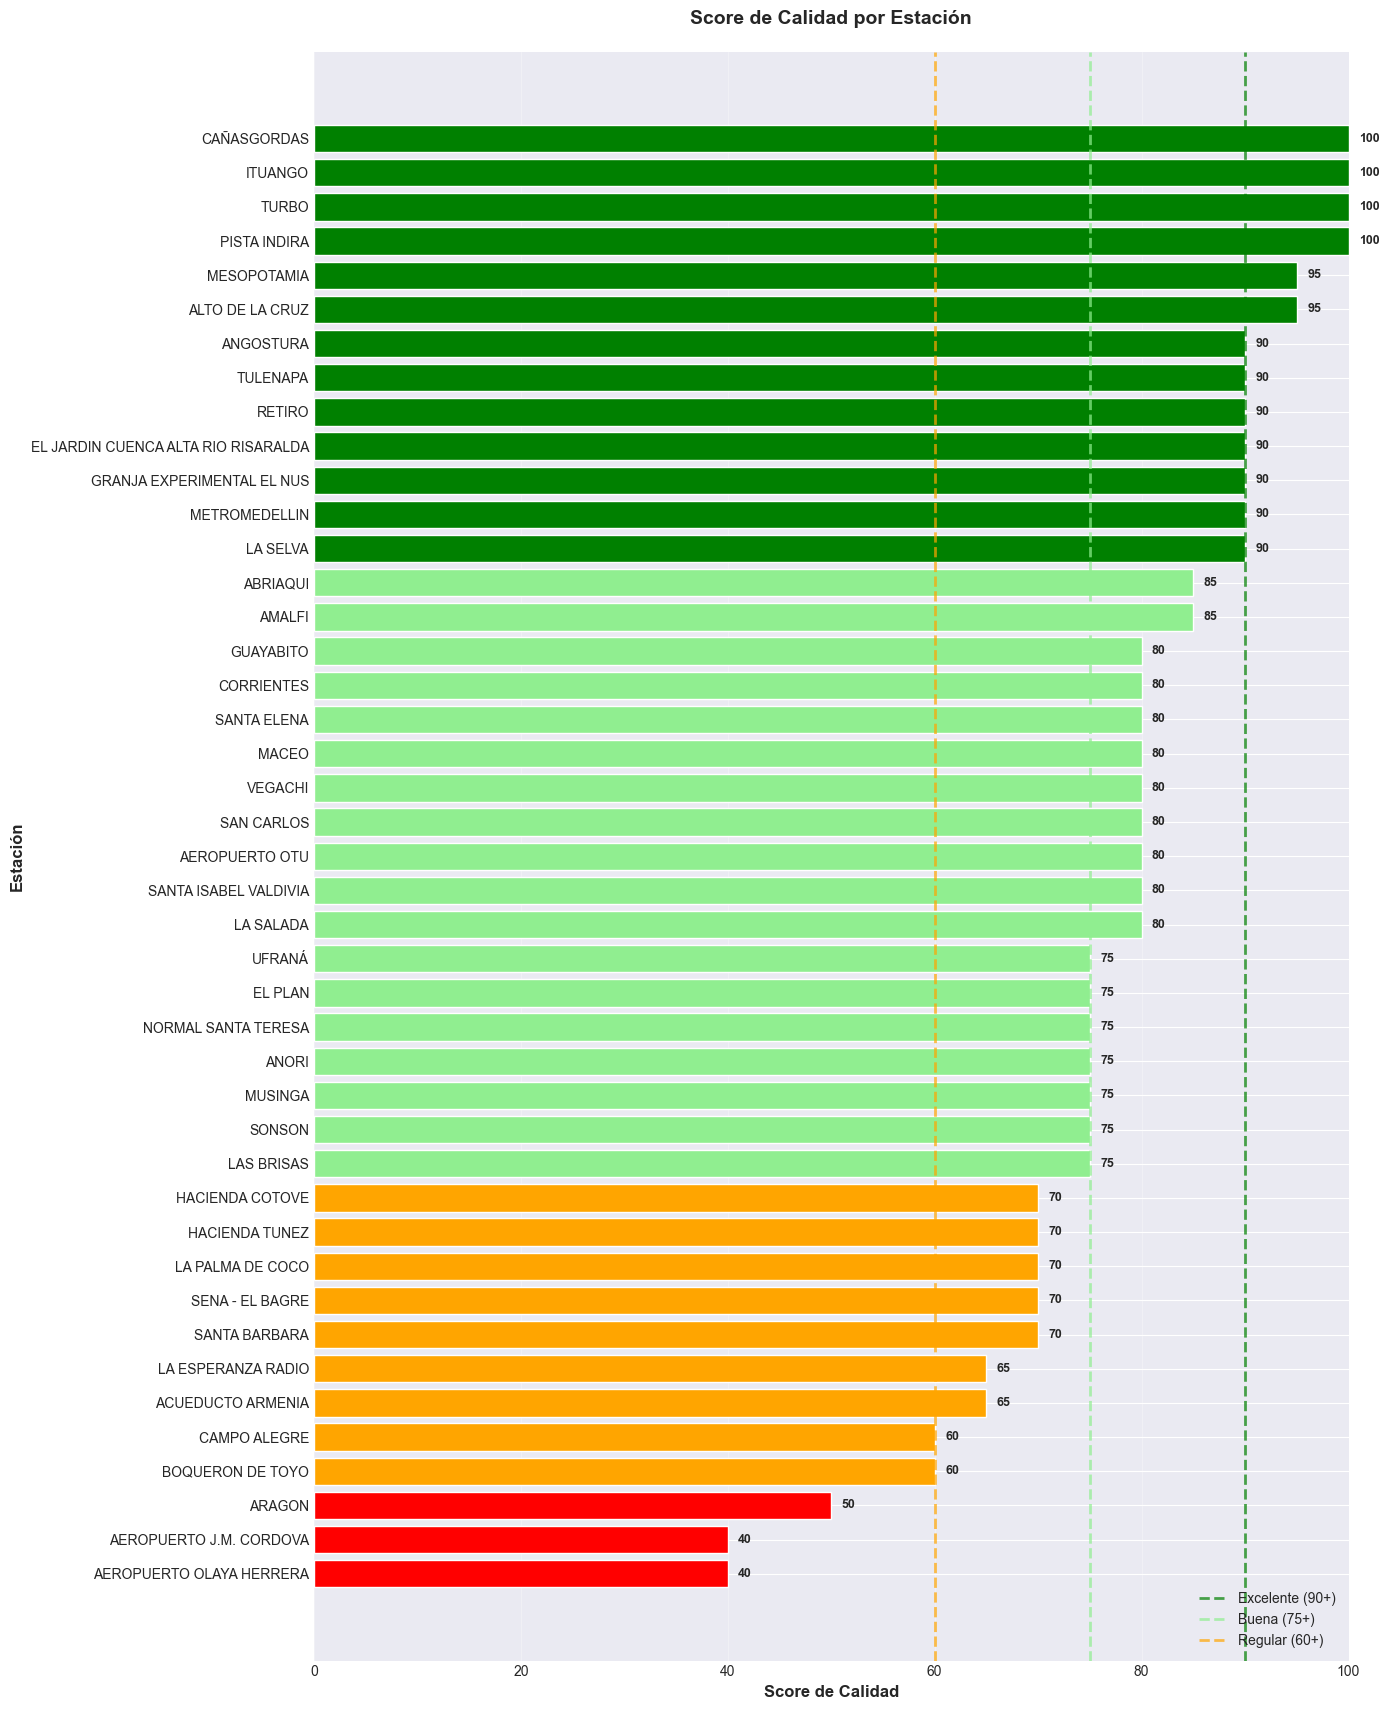

✓ Gráfico 1: Score de calidad por estación


In [24]:
# Gráfico 1: Score de calidad por estación (barras horizontales)
if 'df_calidad_global' in globals() and len(df_calidad_global) > 0:
    fig, ax = plt.subplots(figsize=(14, max(8, len(df_calidad_global) * 0.4)))

    df_sorted = df_calidad_global.sort_values('score_total', ascending=True)
    colors = df_sorted['clasificacion'].map({
        'Excelente': 'green',
        'Buena': 'lightgreen',
        'Regular': 'orange',
        'Deficiente': 'red'
    })

    ax.barh(df_sorted['estacion'], df_sorted['score_total'], color=colors)
    ax.axvline(90, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Excelente (90+)')
    ax.axvline(75, color='lightgreen', linestyle='--', linewidth=2, alpha=0.7, label='Buena (75+)')
    ax.axvline(60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Regular (60+)')
    ax.set_xlabel('Score de Calidad', fontsize=12, fontweight='bold')
    ax.set_ylabel('Estación', fontsize=12, fontweight='bold')
    ax.set_title('Score de Calidad por Estación', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 100)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3)

    # Añadir valores en las barras
    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        ax.text(row['score_total'] + 1, i, f"{row['score_total']:.0f}",
               va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("✓ Gráfico 1: Score de calidad por estación")
else:
    print("⚠️  No hay datos de calidad para visualizar")

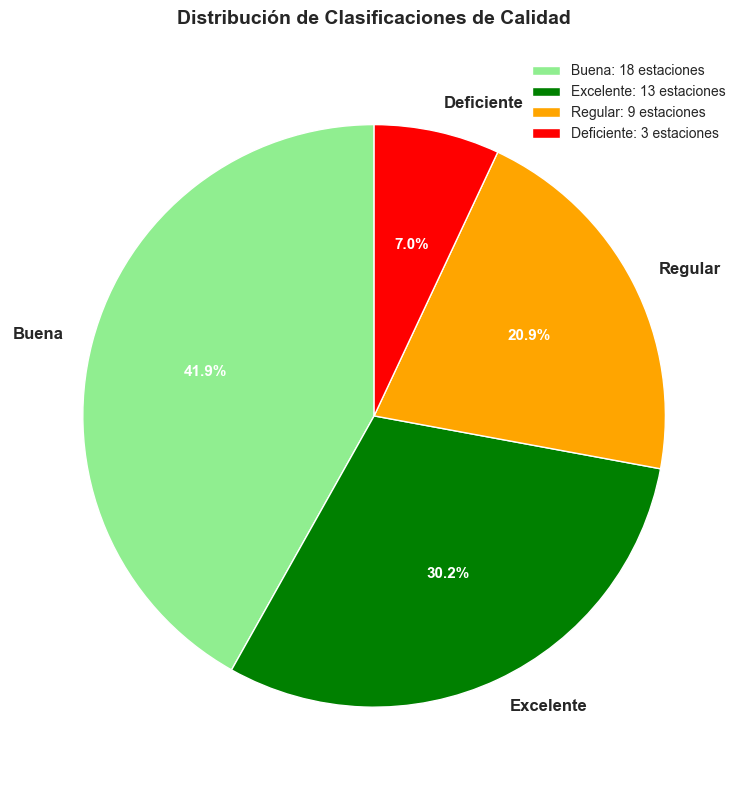

✓ Gráfico 2: Distribución de clasificaciones


In [41]:
# Gráfico 2: Distribución de clasificaciones (pie chart)
if 'df_calidad_global' in globals() and len(df_calidad_global) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))

    clasificaciones = df_calidad_global['clasificacion'].value_counts()
    colors_pie = {'Excelente': 'green', 'Buena': 'lightgreen', 'Regular': 'orange', 'Deficiente': 'red'}
    pie_colors = [colors_pie.get(label, 'gray') for label in clasificaciones.index]

    wedges, texts, autotexts = ax.pie(clasificaciones.values, labels=clasificaciones.index,
                                        autopct='%1.1f%%', colors=pie_colors, startangle=90,
                                        textprops={'fontsize': 12, 'fontweight': 'bold'})

    # Mejorar formato de porcentajes
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)

    ax.set_title('Distribución de Clasificaciones de Calidad', fontsize=14, fontweight='bold', pad=20)

    # Añadir leyenda con conteos
    legend_labels = [f'{label}: {count} estaciones' for label, count in clasificaciones.items()]
    ax.legend(legend_labels, loc='best', fontsize=10)

    plt.tight_layout()
    plt.show()

    print("✓ Gráfico 2: Distribución de clasificaciones")
else:
    print("⚠️  No hay datos de calidad para visualizar")

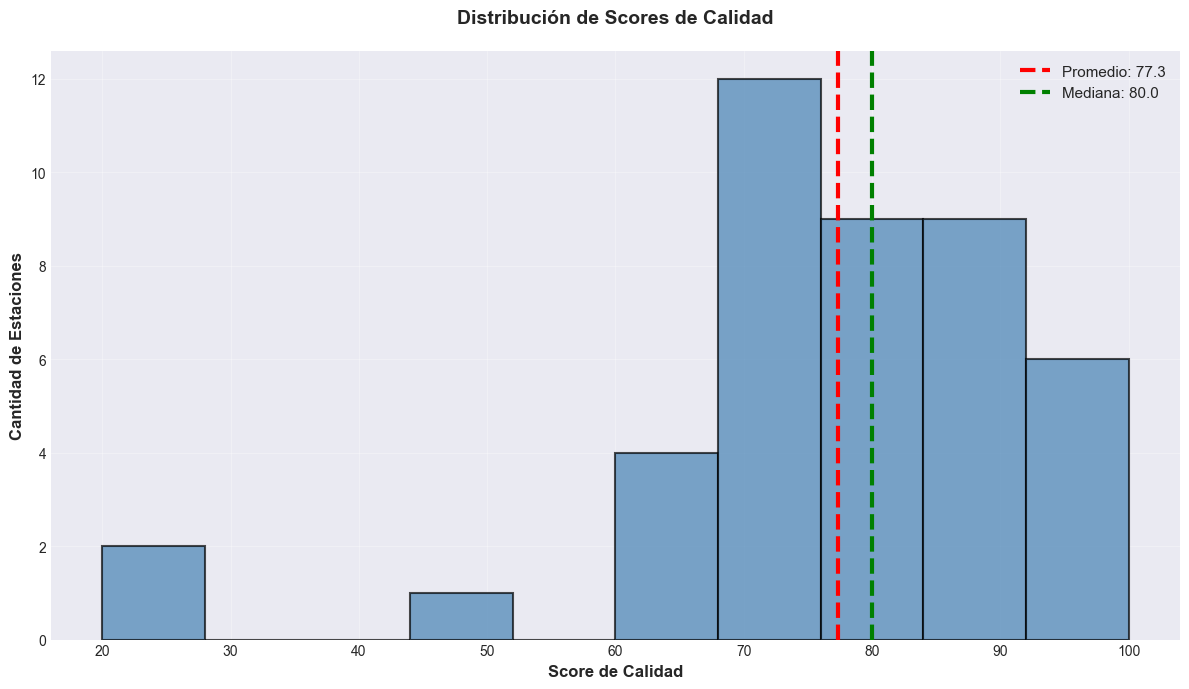

✓ Gráfico 3: Histograma de scores
  Rango: [20.0 - 100.0]
  Desviación estándar: 17.26


In [42]:
# Gráfico 3: Histograma de scores
if 'df_calidad_global' in globals() and len(df_calidad_global) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.hist(df_calidad_global['score_total'], bins=10, color='steelblue',
            edgecolor='black', alpha=0.7, linewidth=1.5)
    ax.axvline(df_calidad_global['score_total'].mean(), color='red', linestyle='--',
               linewidth=3, label=f'Promedio: {df_calidad_global["score_total"].mean():.1f}')
    ax.axvline(df_calidad_global['score_total'].median(), color='green', linestyle='--',
               linewidth=3, label=f'Mediana: {df_calidad_global["score_total"].median():.1f}')

    ax.set_xlabel('Score de Calidad', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cantidad de Estaciones', fontsize=12, fontweight='bold')
    ax.set_title('Distribución de Scores de Calidad', fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Gráfico 3: Histograma de scores")
    print(f"  Rango: [{df_calidad_global['score_total'].min():.1f} - {df_calidad_global['score_total'].max():.1f}]")
    print(f"  Desviación estándar: {df_calidad_global['score_total'].std():.2f}")
else:
    print("⚠️  No hay datos de calidad para visualizar")

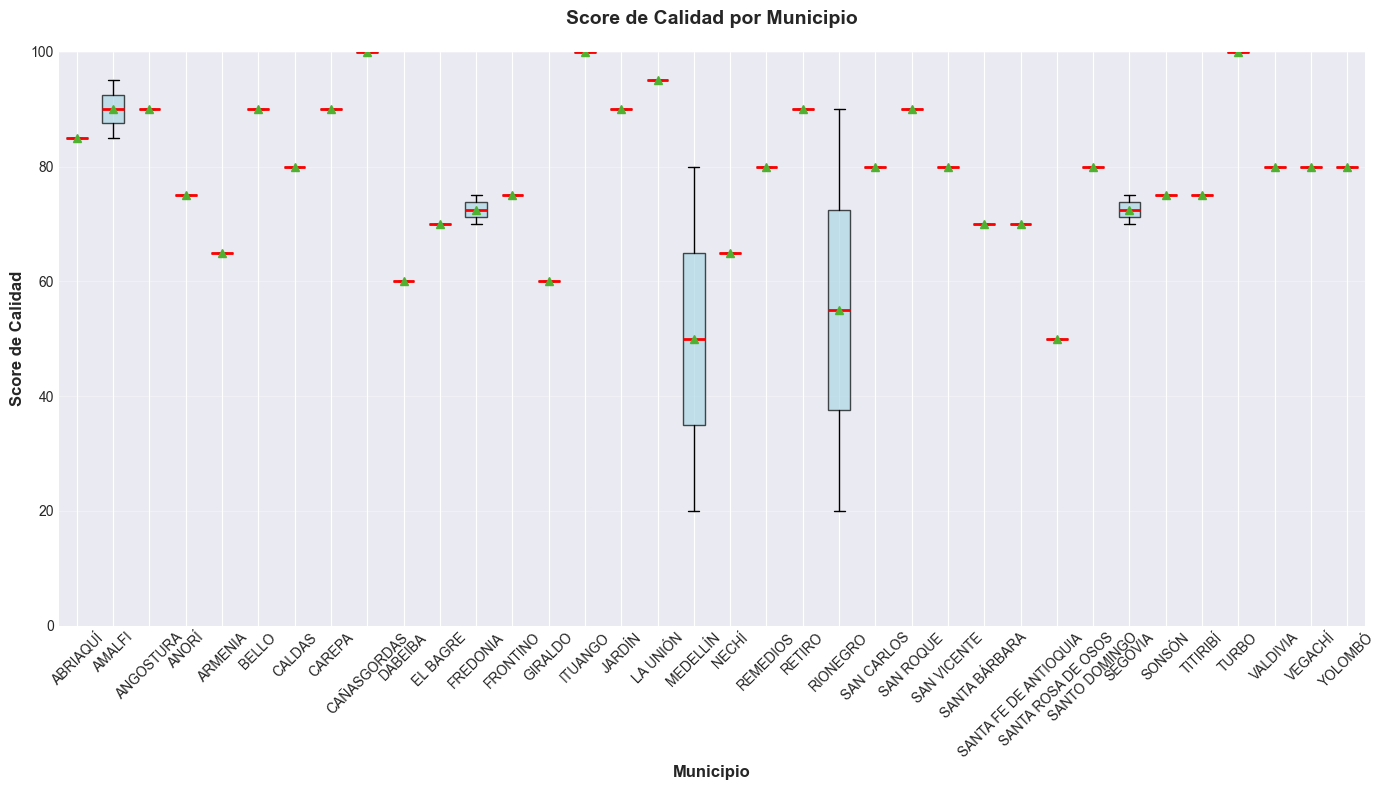

✓ Gráfico 4: Score de calidad por municipio


In [43]:
# Gráfico 4: Box plot de scores por municipio
if 'df_calidad_global' in globals() and len(df_calidad_global) > 0:
    if df_calidad_global['municipio'].nunique() > 1:
        fig, ax = plt.subplots(figsize=(14, 8))

        municipios_data = []
        municipios_labels = []

        for municipio in sorted(df_calidad_global['municipio'].unique()):
            scores = df_calidad_global[df_calidad_global['municipio'] == municipio]['score_total'].values
            if len(scores) > 0:
                municipios_data.append(scores)
                municipios_labels.append(municipio)

        if municipios_data:
            bp = ax.boxplot(municipios_data, labels=municipios_labels, patch_artist=True,
                           widths=0.6, showmeans=True)

            # Personalizar colores
            for patch in bp['boxes']:
                patch.set_facecolor('lightblue')
                patch.set_alpha(0.7)
            for median in bp['medians']:
                median.set_color('red')
                median.set_linewidth(2)

            ax.set_ylabel('Score de Calidad', fontsize=12, fontweight='bold')
            ax.set_xlabel('Municipio', fontsize=12, fontweight='bold')
            ax.set_title('Score de Calidad por Municipio', fontsize=14, fontweight='bold', pad=20)
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='x', rotation=45, labelsize=10)
            ax.set_ylim(0, 100)

            plt.tight_layout()
            plt.show()

            print("✓ Gráfico 4: Score de calidad por municipio")
    else:
        print("ℹ️  Solo hay un municipio - No es posible generar comparación")
else:
    print("⚠️  No hay datos de calidad para visualizar")

### 🔬 Análisis de Calidad por Sensor

Comparamos el desempeño de los diferentes sensores utilizados en el sistema.

In [44]:
# Analizar calidad por sensor
query_calidad_sensor = """
SELECT
    s.nombre as sensor,
    COUNT(DISTINCT o.estacion_id) as num_estaciones,
    COUNT(*) as total_observaciones,
    MIN(o.valor) as temp_minima,
    MAX(o.valor) as temp_maxima,
    AVG(o.valor) as temp_promedio,
    STDDEV(o.valor) as desviacion_std,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY o.valor) as mediana
FROM observaciones o
JOIN sensores s ON o.sensor_id = s.id
{where_clause}
GROUP BY s.nombre
ORDER BY s.nombre;
"""

# Construir cláusulas WHERE
where_clauses = []
if PARAMS['fecha_inicio']:
    where_clauses.append(f"o.fecha >= '{PARAMS['fecha_inicio']}'")
if PARAMS['fecha_fin']:
    where_clauses.append(f"o.fecha <= '{PARAMS['fecha_fin']}'")

where_clause = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""

query_calidad_sensor_final = query_calidad_sensor.format(where_clause=where_clause)

df_calidad_sensor = ejecutar_query(query_calidad_sensor_final, "calidad por sensor")

if df_calidad_sensor is not None and len(df_calidad_sensor) > 0:
    print("🔬 ANÁLISIS DE CALIDAD POR SENSOR")
    print("="*80)

    # Formatear para visualización
    df_sensor_display = df_calidad_sensor.copy()
    df_sensor_display['total_observaciones'] = df_sensor_display['total_observaciones'].apply(lambda x: f'{x:,}')
    for col in ['temp_minima', 'temp_maxima', 'temp_promedio', 'desviacion_std', 'mediana']:
        df_sensor_display[col] = df_sensor_display[col].apply(lambda x: f'{x:.2f}')

    print(df_sensor_display.to_string(index=False))
    print("="*80)

    # Contar problemas por sensor
    print("\nPROBLEMAS DETECTADOS POR SENSOR:")
    for _, sensor_row in df_calidad_sensor.iterrows():
        sensor_nombre = sensor_row['sensor']
        problemas_sensor = []

        # Contar outliers
        outliers_count = 0
        if 'df_outliers_fisicos_global' in globals() and len(df_outliers_fisicos_global) > 0:
            outliers_count += len(df_outliers_fisicos_global[df_outliers_fisicos_global['sensor'] == sensor_nombre])
        if 'df_outliers_iqr_global' in globals() and len(df_outliers_iqr_global) > 0:
            outliers_count += len(df_outliers_iqr_global[df_outliers_iqr_global['sensor'] == sensor_nombre])
        if 'df_outliers_zscore_global' in globals() and len(df_outliers_zscore_global) > 0:
            outliers_count += len(df_outliers_zscore_global[df_outliers_zscore_global['sensor'] == sensor_nombre])

        if outliers_count > 0:
            problemas_sensor.append(f"{outliers_count} outliers")

        # Contar cuasi-duplicados
        if 'df_cuasi_duplicados_global' in globals() and len(df_cuasi_duplicados_global) > 0:
            duplicados_count = len(df_cuasi_duplicados_global[df_cuasi_duplicados_global['sensor'] == sensor_nombre])
            if duplicados_count > 0:
                problemas_sensor.append(f"{duplicados_count} cuasi-duplicados")

        if problemas_sensor:
            print(f"  • {sensor_nombre}: {', '.join(problemas_sensor)}")
        else:
            print(f"  ✓ {sensor_nombre}: Sin problemas detectados")

    print("="*80)

    # Guardar para visualización
    df_calidad_sensor_global = df_calidad_sensor.copy()
else:
    print("⚠️  No se encontraron datos de sensores para analizar")

🔬 ANÁLISIS DE CALIDAD POR SENSOR
                           sensor  num_estaciones total_observaciones temp_minima temp_maxima temp_promedio desviacion_std mediana
GPRS - TEMPERATURA DEL AIRE A 2 m               2             316,141        0.00       50.00         19.44           4.37   19.40
       TEMPERATURA DEL AIRE A 2 m              43             170,166        0.00       45.10         20.55           4.96   20.30

PROBLEMAS DETECTADOS POR SENSOR:
  • GPRS - TEMPERATURA DEL AIRE A 2 m: 3922 outliers, 34 cuasi-duplicados
  • TEMPERATURA DEL AIRE A 2 m: 1049 outliers, 2 cuasi-duplicados


### 📊 Visualización de Comparación entre Sensores

Gráficos comparativos del desempeño de los diferentes sensores.

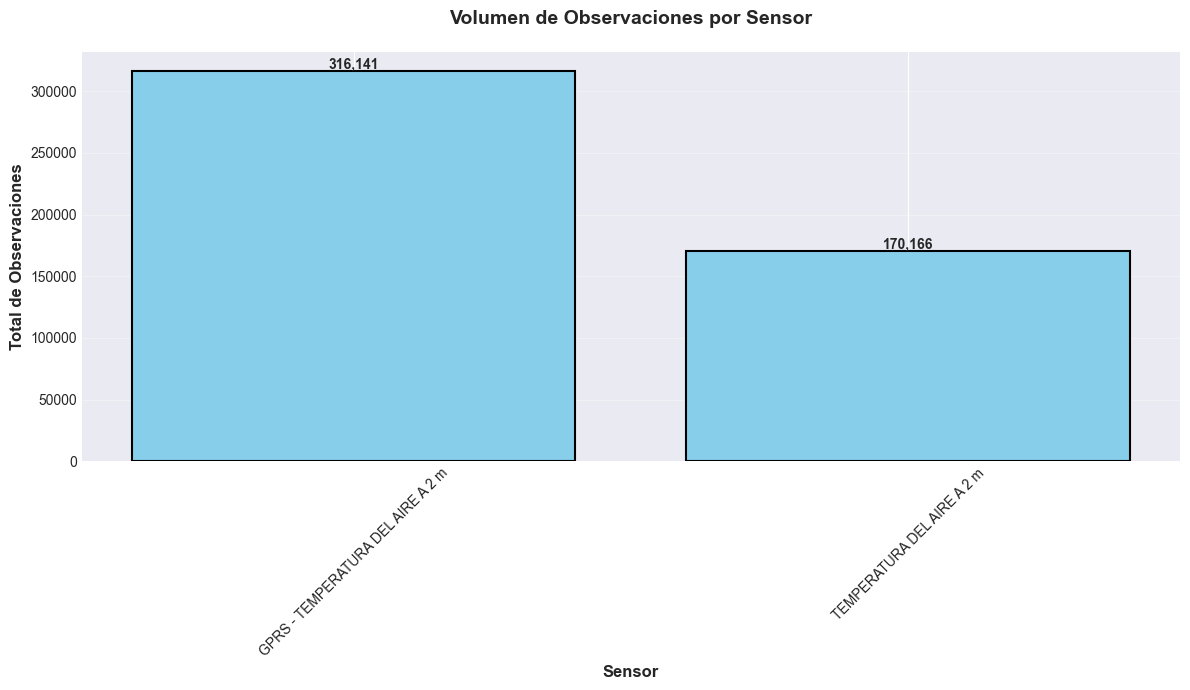

✓ Gráfico: Volumen de observaciones por sensor


In [45]:
# Gráfico: Comparación de volumen de observaciones por sensor
if 'df_calidad_sensor_global' in globals() and len(df_calidad_sensor_global) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.bar(df_calidad_sensor_global['sensor'],
           df_calidad_sensor_global['total_observaciones'],
           color='skyblue', edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Sensor', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total de Observaciones', fontsize=12, fontweight='bold')
    ax.set_title('Volumen de Observaciones por Sensor', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for i, (sensor, total) in enumerate(zip(df_calidad_sensor_global['sensor'],
                                             df_calidad_sensor_global['total_observaciones'])):
        ax.text(i, total, f'{total:,.0f}', ha='center', va='bottom',
               fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("✓ Gráfico: Volumen de observaciones por sensor")
else:
    print("⚠️  No hay datos de sensores para visualizar")

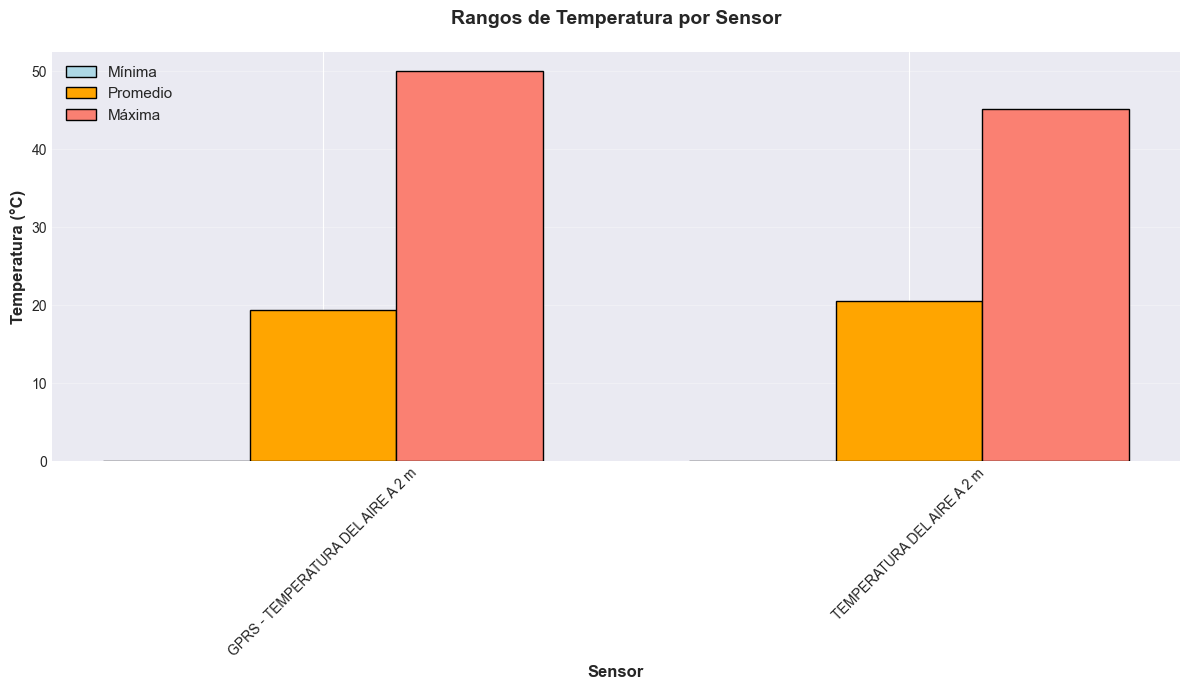

✓ Gráfico: Rangos de temperatura por sensor


In [47]:
# Gráfico: Comparación de rangos de temperatura por sensor
if 'df_calidad_sensor_global' in globals() and len(df_calidad_sensor_global) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))

    x = range(len(df_calidad_sensor_global))
    width = 0.25

    ax.bar([i - width for i in x], df_calidad_sensor_global['temp_minima'],
           width, label='Mínima', color='lightblue', edgecolor='black')
    ax.bar(x, df_calidad_sensor_global['temp_promedio'],
           width, label='Promedio', color='orange', edgecolor='black')
    ax.bar([i + width for i in x], df_calidad_sensor_global['temp_maxima'],
           width, label='Máxima', color='salmon', edgecolor='black')

    ax.set_xlabel('Sensor', fontsize=12, fontweight='bold')
    ax.set_ylabel('Temperatura (°C)', fontsize=12, fontweight='bold')
    ax.set_title('Rangos de Temperatura por Sensor', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(df_calidad_sensor_global['sensor'], rotation=45)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Gráfico: Rangos de temperatura por sensor")
else:
    print("⚠️  No hay datos de sensores para visualizar")

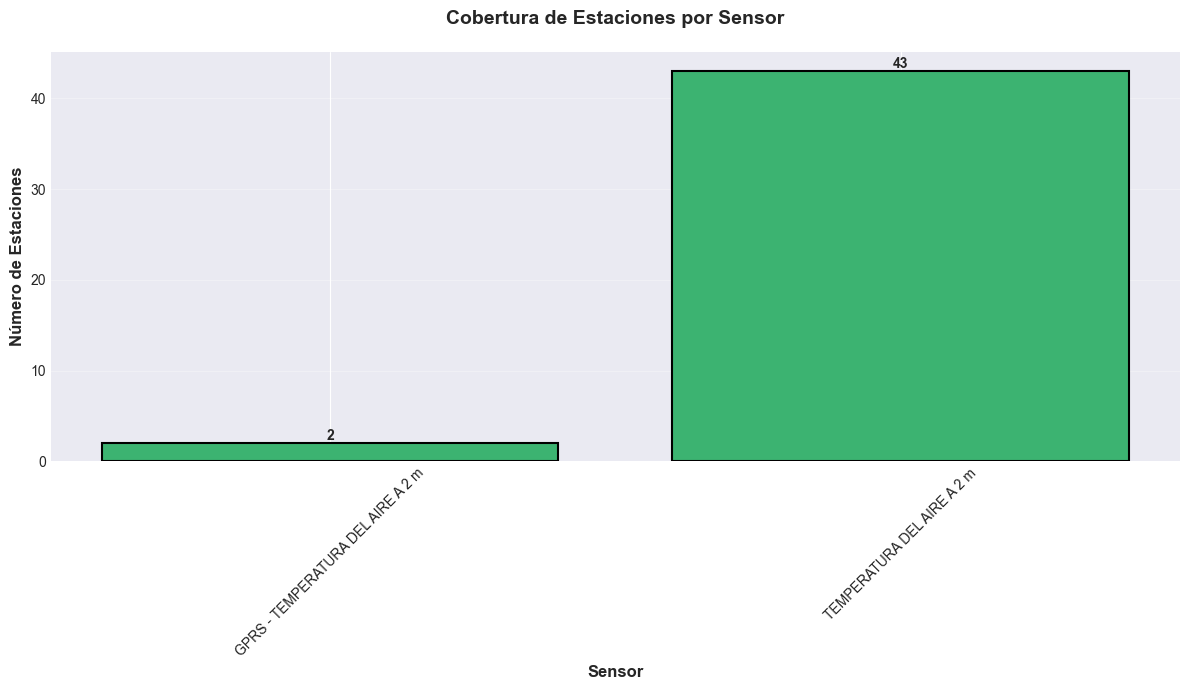

✓ Gráfico: Cobertura de estaciones por sensor


In [48]:
# Gráfico: Número de estaciones por sensor
if 'df_calidad_sensor_global' in globals() and len(df_calidad_sensor_global) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.bar(df_calidad_sensor_global['sensor'],
           df_calidad_sensor_global['num_estaciones'],
           color='mediumseagreen', edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Sensor', fontsize=12, fontweight='bold')
    ax.set_ylabel('Número de Estaciones', fontsize=12, fontweight='bold')
    ax.set_title('Cobertura de Estaciones por Sensor', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for i, (sensor, num) in enumerate(zip(df_calidad_sensor_global['sensor'],
                                          df_calidad_sensor_global['num_estaciones'])):
        ax.text(i, num, f'{num}', ha='center', va='bottom',
               fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("✓ Gráfico: Cobertura de estaciones por sensor")
else:
    print("⚠️  No hay datos de sensores para visualizar")

---

## 8️⃣ Reporte de Calidad y Recomendaciones

### 📋 Resumen Ejecutivo de Calidad de Datos

Consolidamos todos los hallazgos y generamos recomendaciones accionables.

In [49]:
# Generar reporte consolidado de calidad
print("="*80)
print(" "*20 + "REPORTE DE CALIDAD DE DATOS")
print(" "*15 + "Sistema de Temperatura - Antioquia")
print("="*80)

# 1. INFORMACIÓN GENERAL
print("\n📊 1. INFORMACIÓN GENERAL DEL ANÁLISIS")
print("-"*80)
print(f"  Período analizado: {PARAMS['fecha_inicio'] or 'Inicio de datos'} a {PARAMS['fecha_fin'] or 'Fin de datos'}")
if 'df_periodo' in globals():
    print(f"  Primera observación: {df_periodo['primera_observacion'].iloc[0]}")
    print(f"  Última observación: {df_periodo['ultima_observacion'].iloc[0]}")
    print(f"  Total observaciones: {df_periodo['total_observaciones'].iloc[0]:,}")
    print(f"  Días con datos: {df_periodo['dias_con_datos'].iloc[0]:,}")

if 'df_estaciones' in globals():
    print(f"  Total estaciones: {len(df_estaciones)}")
if 'df_sensores' in globals():
    print(f"  Total sensores: {len(df_sensores)}")

# 2. COMPLETITUD DE DATOS
print("\n📈 2. COMPLETITUD DE DATOS")
print("-"*80)
if 'df_gaps' in globals() and len(df_gaps) > 0:
    print(f"  ⚠️  Gaps temporales detectados: {df_gaps['num_gaps'].sum():,}")
    print(f"  Estaciones afectadas: {len(df_gaps)}")
    print(f"  Total horas perdidas: {df_gaps['total_horas_perdidas'].sum():,.1f}")
    print(f"  Gap más largo: {df_gaps['gap_maximo_horas'].max():.1f} horas")
else:
    print(f"  ✓ No se detectaron gaps significativos (> {PARAMS['gap_maximo_horas']} horas)")

# 3. CONSISTENCIA TEMPORAL
print("\n⏱️  3. CONSISTENCIA TEMPORAL")
print("-"*80)
if 'df_intervalos' in globals() and len(df_intervalos) > 0:
    print(f"  Frecuencia esperada: {PARAMS['frecuencia_esperada_minutos']} minutos")
    print(f"  Frecuencia promedio real: {df_intervalos['intervalo_promedio'].mean():.1f} minutos")
    print(f"  Frecuencia mediana real: {df_intervalos['intervalo_mediana'].median():.1f} minutos")
    diferencia = abs(df_intervalos['intervalo_promedio'].mean() - PARAMS['frecuencia_esperada_minutos'])
    if diferencia < 5:
        print(f"  ✓ La frecuencia real está dentro del rango esperado")
    else:
        print(f"  ⚠️  Desviación de {diferencia:.1f} minutos respecto a lo esperado")

# 4. OUTLIERS
print("\n🚨 4. DETECCIÓN DE OUTLIERS")
print("-"*80)

total_outliers = 0
if 'df_outliers_fisicos_global' in globals() and len(df_outliers_fisicos_global) > 0:
    print(f"  Outliers por límites físicos: {len(df_outliers_fisicos_global):,}")
    total_outliers += len(df_outliers_fisicos_global)
else:
    print(f"  ✓ No se detectaron outliers por límites físicos")

if 'df_outliers_iqr_global' in globals() and len(df_outliers_iqr_global) > 0:
    print(f"  Outliers por método IQR: {len(df_outliers_iqr_global):,}")
    total_outliers += len(df_outliers_iqr_global)
else:
    print(f"  ✓ No se detectaron outliers por método IQR")

if 'df_outliers_zscore_global' in globals() and len(df_outliers_zscore_global) > 0:
    print(f"  Outliers por método Z-score: {len(df_outliers_zscore_global):,}")
    total_outliers += len(df_outliers_zscore_global)
else:
    print(f"  ✓ No se detectaron outliers por método Z-score")

if total_outliers > 0:
    if 'df_periodo' in globals():
        porcentaje_outliers = (total_outliers / df_periodo['total_observaciones'].iloc[0]) * 100
        print(f"  Total outliers únicos: ~{total_outliers:,} ({porcentaje_outliers:.2f}% del total)")

# 5. DUPLICADOS
print("\n🔄 5. DUPLICADOS")
print("-"*80)
if 'df_duplicados_exactos_global' in globals() and len(df_duplicados_exactos_global) > 0:
    print(f"  ⚠️  Duplicados exactos: {len(df_duplicados_exactos_global):,} grupos")
else:
    print(f"  ✓ No se detectaron duplicados exactos")

if 'df_cuasi_duplicados_global' in globals() and len(df_cuasi_duplicados_global) > 0:
    print(f"  ⚠️  Cuasi-duplicados: {len(df_cuasi_duplicados_global):,}")
else:
    print(f"  ✓ No se detectaron cuasi-duplicados")

# 6. CALIDAD POR DIMENSIONES
print("\n📊 6. CALIDAD POR DIMENSIONES")
print("-"*80)

# Calidad por estación
if 'df_calidad_global' in globals() and len(df_calidad_global) > 0:
    print(f"  Score promedio de calidad: {df_calidad_global['score_total'].mean():.1f}/100")
    print(f"  Score mediano de calidad: {df_calidad_global['score_total'].median():.1f}/100")
    print(f"\n  Clasificación de estaciones:")
    for clasificacion in ['Excelente', 'Buena', 'Regular', 'Deficiente']:
        count = len(df_calidad_global[df_calidad_global['clasificacion'] == clasificacion])
        if count > 0:
            porcentaje = (count / len(df_calidad_global)) * 100
            print(f"    - {clasificacion}: {count} estaciones ({porcentaje:.1f}%)")

# Calidad por sensor
if 'df_calidad_sensor_global' in globals() and len(df_calidad_sensor_global) > 0:
    print(f"\n  Sensores analizados: {len(df_calidad_sensor_global)}")
    mejor_sensor = df_calidad_sensor_global.loc[df_calidad_sensor_global['total_observaciones'].idxmax()]
    print(f"    - Sensor con más datos: {mejor_sensor['sensor']} ({mejor_sensor['total_observaciones']:,.0f} obs)")

print("\n" + "="*80)

                    REPORTE DE CALIDAD DE DATOS
               Sistema de Temperatura - Antioquia

📊 1. INFORMACIÓN GENERAL DEL ANÁLISIS
--------------------------------------------------------------------------------
  Período analizado: 2025-01-01 a 2025-10-01
  Primera observación: 2025-01-01 00:00:00+00:00
  Última observación: 2025-09-30 23:58:00+00:00
  Total observaciones: 486,307
  Días con datos: 235
  Total estaciones: 43
  Total sensores: 2

📈 2. COMPLETITUD DE DATOS
--------------------------------------------------------------------------------
  ⚠️  Gaps temporales detectados: 751
  Estaciones afectadas: 39
  Total horas perdidas: 56,037.0
  Gap más largo: 1767.0 horas

⏱️  3. CONSISTENCIA TEMPORAL
--------------------------------------------------------------------------------
  Frecuencia esperada: 60 minutos
  Frecuencia promedio real: 58.0 minutos
  Frecuencia mediana real: 60.0 minutos
  ✓ La frecuencia real está dentro del rango esperado

🚨 4. DETECCIÓN DE OUTLIERS
